# Age, gender and race prediction from face images using Pytorch

In this task we have some cropped face images, each image is associated with three labels : 
* Age
* Gender : `Male` or `Female`
* Race : `White`, `Black`,  `Asian`, `Indian` or `Other`

So the objective is to train a model that can predict these three characteristics from face image. This is referred to as multistak learning as we have mutiple labels to predict for each image, and we'll use Pytorch for this purpose. So let's start!

## 1. Install packages
I Gathered all my preprocessing and model training utility functions/classes in a small package I called DEmoClassi (sorry for the name, my inspiration went away at that time 😜) which stands for **D**emographic (Age, gender, race) and **Emo**tion **Classi**fication.

This package contains three modules : `emotion_detection`, `multitask_rag` and `vision_utils`.

In [0]:
!pip install --upgrade democlassi

    100% |████████████████████████████████| 10.1MB 4.8MB/s 
    100% |████████████████████████████████| 81kB 28.4MB/s 
    100% |████████████████████████████████| 133kB 31.3MB/s 


In [0]:
import torch
import torchvision.transforms as transforms

from vision_utils.custom_torch_utils import load_model
from vision_utils.custom_architectures import SepConvModelMT, SepConvModel, initialize_model, PretrainedMT


from multitask_rag.train import run_utk
from multitask_rag.utk_data_utils import get_utk_dataloader, split_utk
from multitask_rag.evaluate import evaluate_model as eval_utk

import numpy as np
import tqdm
import glob
import os

from google.colab import drive

The UTK face datasets which I am going to use and which can be [downloaded here](https://drive.google.com/open?id=0BxYys69jI14kYVM3aVhKS1VhRUk) is located in my google drive, so I need to mount my google drive folder in order to copy the data locally on googlr colab :

In [0]:
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
# Create a directory where to store data
os.makedirs('/content/data', exist_ok=True)

In [0]:
# copy the data from google drive
!cp gdrive/My\ Drive/DeepLearning/Face_detection/utk_face.zip /content/data/

And finally extract the data

In [0]:
!unzip data/utk_face.zip -d data/

Archive:  data/utk_face.zip
  inflating: data/crop_part1.tar.gz  
  inflating: data/UTKFace.tar.gz     


In [0]:
# extract the images
!tar -C data/ -xzf data/UTKFace.tar.gz

In [0]:
# print content of the data directory
!ls /content/data/

crop_part1.tar.gz  UTKFace  UTKFace.tar.gz  utk_face.zip


In [0]:
list_images = glob.glob('/content/data/UTKFace/*jp*')
print(len(list_images))

23708


We have 23708 images in total, and the labels are given in the image names. the image names format is the following : `age_gender_race_date`.
for instance this image name `1_0_0_20161219140623097.jpg.chip.jpg` suggests that the image corresponds to a person whose age is `1`, gender is `0` (Male) and race is `0` (White).
However there are few images for which the name is malfomed, so we remove them using the following code snippet :

In [0]:
# function to remove invalid images (that he filenames is not correctly formatted)
def get_invalid_images(root_path='/content/data/UTKFace/'):
    list_files = glob.glob(os.path.join(root_path, '*.[jJ][pP]*'))
    filenames = [path.split('/')[-1].split('_') for path in list_files]
    print()
    invalid_images = []
    for i, im in enumerate(tqdm.tqdm(filenames)):
        if im[0].isdigit() and im[1].isdigit() and im[2].isdigit():
            continue
        else:
            invalid_images.append(list_files[i])
    return invalid_images

In [0]:
invalid_images = get_invalid_images()
print(invalid_images)

100%|██████████| 23708/23708 [00:00<00:00, 1356726.55it/s]


['/content/data/UTKFace/39_1_20170116174525125.jpg.chip.jpg', '/content/data/UTKFace/61_1_20170109150557335.jpg.chip.jpg', '/content/data/UTKFace/61_1_20170109142408075.jpg.chip.jpg']


In [0]:
# Remove invalid files
for f in invalid_images:
    os.remove(f)

## 2. Some data pre-processing operations

Now that we have our dataset ready let's split it into training (70%), test (15%) and validation (15%) sets:

In [0]:
# split the dataset into train, test and validation sets 
SRC_DIR = '/content/data/UTKFace/'  # path to the folder containing all images
DEST_DIR = '/content/data/utk_split/' # path where to save the split dataset, 3 subdirectories will be created (train, valid and test)
SPLIT = 0.7 # ratio of the train set, the remaining (30%) will be split equally between validation and test sets

In [0]:
split_utk(SRC_DIR, DEST_DIR, SPLIT)

  4%|▍         | 654/16593 [00:00<00:02, 6538.23it/s]

------------Copying train images-------------


 18%|█▊        | 627/3556 [00:00<00:00, 6267.97it/s]

------------Copying valid images-------------


 17%|█▋        | 587/3556 [00:00<00:00, 5868.79it/s]

------------Copying test images-------------


100%|██████████| 3556/3556 [00:00<00:00, 4139.23it/s]


Let's also define some transformations we would like to apply :
* Resize all images to 128 x 128
* convert them to pytorch tensors before feeding to the model

In [0]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

The last step before training is to create  DataLoader objects, which are pytorch generator-like objects for yielding data into batches during training :

In [0]:
train_loader = get_utk_dataloader(batch_size=128, data_dir=DEST_DIR, data_transforms=data_transforms, flag='train')
val_loader = get_utk_dataloader(batch_size=128, data_dir=DEST_DIR, data_transforms=data_transforms, flag='valid')

my_data_loaders = {
    'train': train_loader,
    'valid': val_loader
}

## 3. Training

We'll trry three different architectures : 
* CNN based on Depthwise separable convolutions blocks
* Finetuning a pretrained Resnet50
* Finetuning a pretrained VGG19

### 3.1 Deptwhise Separable Convolutions architecture

In [0]:
# Sepconv with adam

my_model = SepConvModelMT(dropout=0.7, n_class=[1, 2, 5], n_filters=[64, 128, 256, 512], kernels_size=[3, 3, 3, 3])
my_optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-3)

We have created above a model and an Adam optimizer. The model has the following parameters :
* `dropout` = 0.7 : we apply a droput of 70%
* `n_class` = [1, 2, 5] : the model has 3 outputs that are age (a scalar thus a shape of 1), gender (male or female thus a shape of 2) and race (white, black, asian, indian or other thus a shape of 5).
*`n_filters` =  [64, 128, 256, 512] : number of features maps for each conv block
* `kernels_size` = [3, 3, 3, 3] : conv kernel size for each conv block

I also need to periodically backup the model's checkpoints in my google drive in case I get disconnected to google colab due to connectivity issues or anything else :


In [0]:
backup_path = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/sep_conv_adam"
os.makedirs(backup_path, exist_ok=True)

Before starting training, let's clarify some important input arguments to the training function that are not quite clear :
* `log_interval` : print the training loss each `log_interval` iterations
* `dirname` : path to the directory where to locally save the best model checkpoint after each epoch
* `filename_prefix` : file name under which to save the model checkpoint
* `n_saved` : save the `n_saved` best models
* `launch_tensorboard` and `log_dir` :  whether to write tensorboard summaries, and if True, write them under `log_dir` folder
* `patience`: number of epochs to wait for before stopping training if no improvement is observed
* `resume_model` and `resume_optimizer` : optional paths to previously trained model and optimizer to start use them as starting point for the training
* `backup_step` and `backup_path` : copy the saved checkpoints from `dirname` to `backup_path` each `backup_step` epochs
* `n_epochs_freeze` : unfreeze the frozen layers after `n_epochs_freeze`, this is particularly used in case of finetuning a pretrained model
* `lr_after_freeze` : in case of finetuning a pretrained model, new learning rate to set after unfreezing frozen layers
* `loss_weights` : the model's outputs (age, gender, race) are not of the same magnitude, wo we made need to assign them different weights representing their respective contributions to the global loss



Now that it's a little bit clearer let's start training :

Number of trainable parameters : 706,278
Number of non-trainable parameters : 0


ITERATION - loss: 10.693: 100%|██████████| 130/130 [02:54<00:00,  1.15it/s]

Training Results - Epoch: 1 Age L1-loss: 31.704 ** Gender accuracy: 0.525 ** Race accuracy: 0.462 ** Avg loss: 13.038


ITERATION - loss: 10.693: 100%|██████████| 130/130 [03:06<00:00,  1.15it/s]

Validation Results - Epoch: 1 Age L1-loss: 31.058 ** Gender accuracy: 0.526 ** Race accuracy: 0.456 ** Avg loss: 12.997


ITERATION - loss: 9.345: 100%|██████████| 130/130 [06:01<00:00,  1.16it/s]

Training Results - Epoch: 2 Age L1-loss: 30.515 ** Gender accuracy: 0.749 ** Race accuracy: 0.510 ** Avg loss: 9.207


ITERATION - loss: 9.345: 100%|██████████| 130/130 [06:12<00:00,  1.16it/s]

Validation Results - Epoch: 2 Age L1-loss: 29.866 ** Gender accuracy: 0.759 ** Race accuracy: 0.510 ** Avg loss: 9.084


ITERATION - loss: 7.820: 100%|██████████| 130/130 [09:07<00:00,  1.15it/s]

Training Results - Epoch: 3 Age L1-loss: 27.112 ** Gender accuracy: 0.763 ** Race accuracy: 0.509 ** Avg loss: 9.077


ITERATION - loss: 7.820: 100%|██████████| 130/130 [09:19<00:00,  1.15it/s]

Validation Results - Epoch: 3 Age L1-loss: 26.565 ** Gender accuracy: 0.767 ** Race accuracy: 0.516 ** Avg loss: 9.015


ITERATION - loss: 6.379: 100%|██████████| 130/130 [12:20<00:00,  1.12it/s]

Training Results - Epoch: 4 Age L1-loss: 18.477 ** Gender accuracy: 0.729 ** Race accuracy: 0.513 ** Avg loss: 8.391


ITERATION - loss: 6.379: 100%|██████████| 130/130 [12:32<00:00,  1.12it/s]

Validation Results - Epoch: 4 Age L1-loss: 18.202 ** Gender accuracy: 0.710 ** Race accuracy: 0.511 ** Avg loss: 8.657


ITERATION - loss: 6.373: 100%|██████████| 130/130 [15:34<00:00,  1.11it/s]

Training Results - Epoch: 5 Age L1-loss: 15.677 ** Gender accuracy: 0.867 ** Race accuracy: 0.570 ** Avg loss: 6.075


ITERATION - loss: 6.373: 100%|██████████| 130/130 [15:47<00:00,  1.11it/s]

Validation Results - Epoch: 5 Age L1-loss: 15.503 ** Gender accuracy: 0.853 ** Race accuracy: 0.569 ** Avg loss: 6.243


ITERATION - loss: 6.033: 100%|██████████| 130/130 [18:47<00:00,  1.16it/s]

Training Results - Epoch: 6 Age L1-loss: 15.069 ** Gender accuracy: 0.889 ** Race accuracy: 0.601 ** Avg loss: 5.577


ITERATION - loss: 6.033: 100%|██████████| 130/130 [18:59<00:00,  1.16it/s]

Validation Results - Epoch: 6 Age L1-loss: 14.962 ** Gender accuracy: 0.870 ** Race accuracy: 0.593 ** Avg loss: 5.822


ITERATION - loss: 5.625: 100%|██████████| 130/130 [21:55<00:00,  1.15it/s]

Training Results - Epoch: 7 Age L1-loss: 15.065 ** Gender accuracy: 0.888 ** Race accuracy: 0.621 ** Avg loss: 5.478


ITERATION - loss: 5.625: 100%|██████████| 130/130 [22:07<00:00,  1.15it/s]

Validation Results - Epoch: 7 Age L1-loss: 14.959 ** Gender accuracy: 0.873 ** Race accuracy: 0.621 ** Avg loss: 5.773


ITERATION - loss: 5.260: 100%|██████████| 130/130 [25:04<00:00,  1.15it/s]

Training Results - Epoch: 8 Age L1-loss: 15.059 ** Gender accuracy: 0.873 ** Race accuracy: 0.619 ** Avg loss: 5.819


ITERATION - loss: 5.260: 100%|██████████| 130/130 [25:15<00:00,  1.15it/s]

Validation Results - Epoch: 8 Age L1-loss: 14.958 ** Gender accuracy: 0.859 ** Race accuracy: 0.618 ** Avg loss: 6.026


ITERATION - loss: 5.159: 100%|██████████| 130/130 [28:17<00:00,  1.07it/s]

Training Results - Epoch: 9 Age L1-loss: 15.034 ** Gender accuracy: 0.901 ** Race accuracy: 0.654 ** Avg loss: 5.177


ITERATION - loss: 5.159: 100%|██████████| 130/130 [28:29<00:00,  1.07it/s]

Validation Results - Epoch: 9 Age L1-loss: 14.930 ** Gender accuracy: 0.886 ** Race accuracy: 0.650 ** Avg loss: 5.484


ITERATION - loss: 5.772: 100%|██████████| 130/130 [31:31<00:00,  1.11it/s]

Training Results - Epoch: 10 Age L1-loss: 15.024 ** Gender accuracy: 0.901 ** Race accuracy: 0.710 ** Avg loss: 4.833


ITERATION - loss: 5.772: 100%|██████████| 130/130 [31:44<00:00,  1.11it/s]

Validation Results - Epoch: 10 Age L1-loss: 14.925 ** Gender accuracy: 0.876 ** Race accuracy: 0.696 ** Avg loss: 5.216


ITERATION - loss: 4.954: 100%|██████████| 130/130 [34:47<00:00,  1.06it/s]

Training Results - Epoch: 11 Age L1-loss: 15.145 ** Gender accuracy: 0.837 ** Race accuracy: 0.728 ** Avg loss: 5.829


ITERATION - loss: 4.954: 100%|██████████| 130/130 [34:59<00:00,  1.06it/s]

Validation Results - Epoch: 11 Age L1-loss: 15.056 ** Gender accuracy: 0.828 ** Race accuracy: 0.710 ** Avg loss: 6.374


ITERATION - loss: 5.071: 100%|██████████| 130/130 [37:59<00:00,  1.14it/s]

Training Results - Epoch: 12 Age L1-loss: 15.049 ** Gender accuracy: 0.908 ** Race accuracy: 0.622 ** Avg loss: 5.431


ITERATION - loss: 5.071: 100%|██████████| 130/130 [38:11<00:00,  1.14it/s]

Validation Results - Epoch: 12 Age L1-loss: 14.945 ** Gender accuracy: 0.871 ** Race accuracy: 0.616 ** Avg loss: 5.819


ITERATION - loss: 5.286: 100%|██████████| 130/130 [41:11<00:00,  1.07it/s]

Training Results - Epoch: 13 Age L1-loss: 15.028 ** Gender accuracy: 0.918 ** Race accuracy: 0.755 ** Avg loss: 4.356


ITERATION - loss: 5.286: 100%|██████████| 130/130 [41:23<00:00,  1.07it/s]

Validation Results - Epoch: 13 Age L1-loss: 14.926 ** Gender accuracy: 0.884 ** Race accuracy: 0.734 ** Avg loss: 4.926


ITERATION - loss: 5.503: 100%|██████████| 130/130 [44:23<00:00,  1.13it/s]

Training Results - Epoch: 14 Age L1-loss: 15.032 ** Gender accuracy: 0.931 ** Race accuracy: 0.773 ** Avg loss: 4.110


ITERATION - loss: 5.503: 100%|██████████| 130/130 [44:35<00:00,  1.13it/s]

Validation Results - Epoch: 14 Age L1-loss: 14.931 ** Gender accuracy: 0.898 ** Race accuracy: 0.745 ** Avg loss: 4.729


ITERATION - loss: 4.452: 100%|██████████| 130/130 [47:34<00:00,  1.12it/s]

Training Results - Epoch: 15 Age L1-loss: 15.028 ** Gender accuracy: 0.925 ** Race accuracy: 0.783 ** Avg loss: 4.090


ITERATION - loss: 4.452: 100%|██████████| 130/130 [47:46<00:00,  1.12it/s]

Validation Results - Epoch: 15 Age L1-loss: 14.925 ** Gender accuracy: 0.887 ** Race accuracy: 0.756 ** Avg loss: 4.730


ITERATION - loss: 4.767: 100%|██████████| 130/130 [50:46<00:00,  1.13it/s]

Training Results - Epoch: 16 Age L1-loss: 15.041 ** Gender accuracy: 0.934 ** Race accuracy: 0.770 ** Avg loss: 4.090


ITERATION - loss: 4.767: 100%|██████████| 130/130 [50:58<00:00,  1.13it/s]

Validation Results - Epoch: 16 Age L1-loss: 14.948 ** Gender accuracy: 0.904 ** Race accuracy: 0.746 ** Avg loss: 4.715


ITERATION - loss: 3.967: 100%|██████████| 130/130 [53:58<00:00,  1.13it/s]

Training Results - Epoch: 17 Age L1-loss: 15.024 ** Gender accuracy: 0.927 ** Race accuracy: 0.761 ** Avg loss: 4.218


ITERATION - loss: 3.967: 100%|██████████| 130/130 [54:10<00:00,  1.13it/s]

Validation Results - Epoch: 17 Age L1-loss: 14.919 ** Gender accuracy: 0.888 ** Race accuracy: 0.737 ** Avg loss: 4.899


ITERATION - loss: 4.054: 100%|██████████| 130/130 [57:10<00:00,  1.15it/s]

Training Results - Epoch: 18 Age L1-loss: 15.041 ** Gender accuracy: 0.872 ** Race accuracy: 0.744 ** Avg loss: 5.296


ITERATION - loss: 4.054: 100%|██████████| 130/130 [57:22<00:00,  1.15it/s]

Validation Results - Epoch: 18 Age L1-loss: 14.942 ** Gender accuracy: 0.855 ** Race accuracy: 0.713 ** Avg loss: 6.120


ITERATION - loss: 6.418: 100%|██████████| 130/130 [1:00:22<00:00,  1.12it/s]

Training Results - Epoch: 19 Age L1-loss: 15.025 ** Gender accuracy: 0.819 ** Race accuracy: 0.776 ** Avg loss: 5.582


ITERATION - loss: 6.418: 100%|██████████| 130/130 [1:00:34<00:00,  1.12it/s]

Validation Results - Epoch: 19 Age L1-loss: 14.928 ** Gender accuracy: 0.787 ** Race accuracy: 0.746 ** Avg loss: 6.498


ITERATION - loss: 5.200: 100%|██████████| 130/130 [1:03:34<00:00,  1.08it/s]

Training Results - Epoch: 20 Age L1-loss: 15.029 ** Gender accuracy: 0.929 ** Race accuracy: 0.756 ** Avg loss: 4.229


ITERATION - loss: 5.200: 100%|██████████| 130/130 [1:03:46<00:00,  1.08it/s]

Validation Results - Epoch: 20 Age L1-loss: 14.926 ** Gender accuracy: 0.882 ** Race accuracy: 0.732 ** Avg loss: 5.281


ITERATION - loss: 3.817: 100%|██████████| 130/130 [1:06:43<00:00,  1.15it/s]

Training Results - Epoch: 21 Age L1-loss: 15.028 ** Gender accuracy: 0.899 ** Race accuracy: 0.827 ** Avg loss: 4.188


ITERATION - loss: 3.817: 100%|██████████| 130/130 [1:06:54<00:00,  1.15it/s]

Validation Results - Epoch: 21 Age L1-loss: 14.933 ** Gender accuracy: 0.857 ** Race accuracy: 0.787 ** Avg loss: 5.231


ITERATION - loss: 4.379: 100%|██████████| 130/130 [1:09:49<00:00,  1.15it/s]

Training Results - Epoch: 22 Age L1-loss: 15.026 ** Gender accuracy: 0.863 ** Race accuracy: 0.784 ** Avg loss: 5.072


ITERATION - loss: 4.379: 100%|██████████| 130/130 [1:10:00<00:00,  1.15it/s]

Validation Results - Epoch: 22 Age L1-loss: 14.928 ** Gender accuracy: 0.821 ** Race accuracy: 0.754 ** Avg loss: 6.184


ITERATION - loss: 4.148: 100%|██████████| 130/130 [1:12:55<00:00,  1.15it/s]

Training Results - Epoch: 23 Age L1-loss: 15.019 ** Gender accuracy: 0.933 ** Race accuracy: 0.767 ** Avg loss: 4.048


ITERATION - loss: 4.148: 100%|██████████| 130/130 [1:13:07<00:00,  1.15it/s]

Validation Results - Epoch: 23 Age L1-loss: 14.916 ** Gender accuracy: 0.897 ** Race accuracy: 0.741 ** Avg loss: 4.886


ITERATION - loss: 4.057: 100%|██████████| 130/130 [1:16:02<00:00,  1.15it/s]

Training Results - Epoch: 24 Age L1-loss: 15.030 ** Gender accuracy: 0.882 ** Race accuracy: 0.823 ** Avg loss: 4.468


ITERATION - loss: 4.057: 100%|██████████| 130/130 [1:16:14<00:00,  1.15it/s]

Validation Results - Epoch: 24 Age L1-loss: 14.929 ** Gender accuracy: 0.841 ** Race accuracy: 0.771 ** Avg loss: 5.729


ITERATION - loss: 4.918: 100%|██████████| 130/130 [1:19:10<00:00,  1.12it/s]

Training Results - Epoch: 25 Age L1-loss: 15.024 ** Gender accuracy: 0.961 ** Race accuracy: 0.812 ** Avg loss: 3.434


ITERATION - loss: 4.918: 100%|██████████| 130/130 [1:19:22<00:00,  1.12it/s]

Validation Results - Epoch: 25 Age L1-loss: 14.924 ** Gender accuracy: 0.899 ** Race accuracy: 0.770 ** Avg loss: 4.783


ITERATION - loss: 4.337: 100%|██████████| 130/130 [1:22:17<00:00,  1.16it/s]

Training Results - Epoch: 26 Age L1-loss: 15.025 ** Gender accuracy: 0.956 ** Race accuracy: 0.818 ** Avg loss: 3.501


ITERATION - loss: 4.337: 100%|██████████| 130/130 [1:22:29<00:00,  1.16it/s]

Validation Results - Epoch: 26 Age L1-loss: 14.928 ** Gender accuracy: 0.900 ** Race accuracy: 0.768 ** Avg loss: 4.877


ITERATION - loss: 4.798: 100%|██████████| 130/130 [1:25:25<00:00,  1.13it/s]

Training Results - Epoch: 27 Age L1-loss: 15.023 ** Gender accuracy: 0.952 ** Race accuracy: 0.807 ** Avg loss: 3.539


ITERATION - loss: 4.798: 100%|██████████| 130/130 [1:25:37<00:00,  1.13it/s]

Validation Results - Epoch: 27 Age L1-loss: 14.919 ** Gender accuracy: 0.900 ** Race accuracy: 0.761 ** Avg loss: 5.039


ITERATION - loss: 4.218: 100%|██████████| 130/130 [1:28:32<00:00,  1.16it/s]

Training Results - Epoch: 28 Age L1-loss: 15.034 ** Gender accuracy: 0.953 ** Race accuracy: 0.846 ** Avg loss: 3.285


ITERATION - loss: 4.218: 100%|██████████| 130/130 [1:28:44<00:00,  1.16it/s]

Validation Results - Epoch: 28 Age L1-loss: 14.929 ** Gender accuracy: 0.902 ** Race accuracy: 0.788 ** Avg loss: 4.818


ITERATION - loss: 3.553: 100%|██████████| 130/130 [1:31:40<00:00,  1.15it/s]

Training Results - Epoch: 29 Age L1-loss: 15.024 ** Gender accuracy: 0.959 ** Race accuracy: 0.796 ** Avg loss: 3.566


ITERATION - loss: 3.553: 100%|██████████| 130/130 [1:31:52<00:00,  1.15it/s]

Validation Results - Epoch: 29 Age L1-loss: 14.920 ** Gender accuracy: 0.902 ** Race accuracy: 0.748 ** Avg loss: 5.051


ITERATION - loss: 3.482: 100%|██████████| 130/130 [1:34:47<00:00,  1.15it/s]

Training Results - Epoch: 30 Age L1-loss: 15.038 ** Gender accuracy: 0.901 ** Race accuracy: 0.845 ** Avg loss: 4.045


ITERATION - loss: 3.482: 100%|██████████| 130/130 [1:34:59<00:00,  1.15it/s]

Validation Results - Epoch: 30 Age L1-loss: 14.939 ** Gender accuracy: 0.863 ** Race accuracy: 0.787 ** Avg loss: 5.802


ITERATION - loss: 4.335: 100%|██████████| 130/130 [1:37:55<00:00,  1.15it/s]

Training Results - Epoch: 31 Age L1-loss: 15.036 ** Gender accuracy: 0.959 ** Race accuracy: 0.791 ** Avg loss: 3.575


ITERATION - loss: 4.335: 100%|██████████| 130/130 [1:38:06<00:00,  1.15it/s]

Validation Results - Epoch: 31 Age L1-loss: 14.943 ** Gender accuracy: 0.896 ** Race accuracy: 0.749 ** Avg loss: 5.267


ITERATION - loss: 4.056: 100%|██████████| 130/130 [1:41:02<00:00,  1.16it/s]

Training Results - Epoch: 32 Age L1-loss: 15.023 ** Gender accuracy: 0.966 ** Race accuracy: 0.838 ** Avg loss: 3.186


ITERATION - loss: 4.056: 100%|██████████| 130/130 [1:41:13<00:00,  1.16it/s]

Validation Results - Epoch: 32 Age L1-loss: 14.919 ** Gender accuracy: 0.906 ** Race accuracy: 0.778 ** Avg loss: 4.796


ITERATION - loss: 4.510: 100%|██████████| 130/130 [1:44:09<00:00,  1.14it/s]

Training Results - Epoch: 33 Age L1-loss: 15.025 ** Gender accuracy: 0.966 ** Race accuracy: 0.841 ** Avg loss: 3.120


ITERATION - loss: 4.510: 100%|██████████| 130/130 [1:44:21<00:00,  1.14it/s]

Validation Results - Epoch: 33 Age L1-loss: 14.925 ** Gender accuracy: 0.903 ** Race accuracy: 0.779 ** Avg loss: 5.074


ITERATION - loss: 3.898: 100%|██████████| 130/130 [1:47:16<00:00,  1.15it/s]

Training Results - Epoch: 34 Age L1-loss: 15.025 ** Gender accuracy: 0.892 ** Race accuracy: 0.838 ** Avg loss: 4.416


ITERATION - loss: 3.898: 100%|██████████| 130/130 [1:47:28<00:00,  1.15it/s]

Validation Results - Epoch: 34 Age L1-loss: 14.927 ** Gender accuracy: 0.855 ** Race accuracy: 0.772 ** Avg loss: 6.559


ITERATION - loss: 4.225: 100%|██████████| 130/130 [1:50:23<00:00,  1.14it/s]

Training Results - Epoch: 35 Age L1-loss: 15.020 ** Gender accuracy: 0.834 ** Race accuracy: 0.702 ** Avg loss: 6.667


ITERATION - loss: 4.225: 100%|██████████| 130/130 [1:50:35<00:00,  1.14it/s]

Validation Results - Epoch: 35 Age L1-loss: 14.925 ** Gender accuracy: 0.801 ** Race accuracy: 0.673 ** Avg loss: 7.997


ITERATION - loss: 2.964: 100%|██████████| 130/130 [1:53:31<00:00,  1.15it/s]

Training Results - Epoch: 36 Age L1-loss: 15.019 ** Gender accuracy: 0.971 ** Race accuracy: 0.841 ** Avg loss: 3.056


ITERATION - loss: 2.964: 100%|██████████| 130/130 [1:53:43<00:00,  1.15it/s]

Validation Results - Epoch: 36 Age L1-loss: 14.917 ** Gender accuracy: 0.899 ** Race accuracy: 0.774 ** Avg loss: 5.015


ITERATION - loss: 3.769: 100%|██████████| 130/130 [1:56:38<00:00,  1.15it/s]

Training Results - Epoch: 37 Age L1-loss: 15.020 ** Gender accuracy: 0.975 ** Race accuracy: 0.805 ** Avg loss: 3.215


ITERATION - loss: 3.769: 100%|██████████| 130/130 [1:56:50<00:00,  1.15it/s]

Validation Results - Epoch: 37 Age L1-loss: 14.915 ** Gender accuracy: 0.902 ** Race accuracy: 0.752 ** Avg loss: 5.203


ITERATION - loss: 2.989: 100%|██████████| 130/130 [1:59:45<00:00,  1.16it/s]

Training Results - Epoch: 38 Age L1-loss: 15.023 ** Gender accuracy: 0.980 ** Race accuracy: 0.861 ** Avg loss: 2.809


ITERATION - loss: 2.989: 100%|██████████| 130/130 [1:59:57<00:00,  1.16it/s]

Validation Results - Epoch: 38 Age L1-loss: 14.924 ** Gender accuracy: 0.898 ** Race accuracy: 0.786 ** Avg loss: 4.951


ITERATION - loss: 3.505: 100%|██████████| 130/130 [2:02:54<00:00,  1.15it/s]

Training Results - Epoch: 39 Age L1-loss: 15.027 ** Gender accuracy: 0.970 ** Race accuracy: 0.789 ** Avg loss: 3.425


ITERATION - loss: 3.505: 100%|██████████| 130/130 [2:03:06<00:00,  1.15it/s]

Validation Results - Epoch: 39 Age L1-loss: 14.928 ** Gender accuracy: 0.893 ** Race accuracy: 0.731 ** Avg loss: 5.734


ITERATION - loss: 3.636: 100%|██████████| 130/130 [2:06:00<00:00,  1.15it/s]

Training Results - Epoch: 40 Age L1-loss: 15.025 ** Gender accuracy: 0.978 ** Race accuracy: 0.854 ** Avg loss: 2.825


ITERATION - loss: 3.636: 100%|██████████| 130/130 [2:06:12<00:00,  1.15it/s]

Validation Results - Epoch: 40 Age L1-loss: 14.925 ** Gender accuracy: 0.905 ** Race accuracy: 0.770 ** Avg loss: 5.148


ITERATION - loss: 3.306: 100%|██████████| 130/130 [2:09:07<00:00,  1.14it/s]

Training Results - Epoch: 41 Age L1-loss: 15.024 ** Gender accuracy: 0.963 ** Race accuracy: 0.861 ** Avg loss: 3.009


ITERATION - loss: 3.306: 100%|██████████| 130/130 [2:09:19<00:00,  1.14it/s]

Validation Results - Epoch: 41 Age L1-loss: 14.920 ** Gender accuracy: 0.882 ** Race accuracy: 0.775 ** Avg loss: 5.688


ITERATION - loss: 5.354: 100%|██████████| 130/130 [2:12:13<00:00,  1.16it/s]

Training Results - Epoch: 42 Age L1-loss: 15.020 ** Gender accuracy: 0.955 ** Race accuracy: 0.858 ** Avg loss: 3.163


ITERATION - loss: 5.354: 100%|██████████| 130/130 [2:12:25<00:00,  1.16it/s]

Validation Results - Epoch: 42 Age L1-loss: 14.917 ** Gender accuracy: 0.874 ** Race accuracy: 0.776 ** Avg loss: 5.779


ITERATION - loss: 3.609: 100%|██████████| 130/130 [2:15:22<00:00,  1.13it/s]

Training Results - Epoch: 43 Age L1-loss: 15.030 ** Gender accuracy: 0.936 ** Race accuracy: 0.794 ** Avg loss: 4.144


ITERATION - loss: 3.609: 100%|██████████| 130/130 [2:15:34<00:00,  1.13it/s]

Validation Results - Epoch: 43 Age L1-loss: 14.923 ** Gender accuracy: 0.875 ** Race accuracy: 0.735 ** Avg loss: 6.772


ITERATION - loss: 3.155: 100%|██████████| 130/130 [2:18:29<00:00,  1.15it/s]

Training Results - Epoch: 44 Age L1-loss: 15.020 ** Gender accuracy: 0.958 ** Race accuracy: 0.803 ** Avg loss: 3.456


ITERATION - loss: 3.155: 100%|██████████| 130/130 [2:18:41<00:00,  1.15it/s]

Validation Results - Epoch: 44 Age L1-loss: 14.916 ** Gender accuracy: 0.880 ** Race accuracy: 0.726 ** Avg loss: 6.078


ITERATION - loss: 3.596: 100%|██████████| 130/130 [2:21:37<00:00,  1.15it/s]

Training Results - Epoch: 45 Age L1-loss: 15.053 ** Gender accuracy: 0.770 ** Race accuracy: 0.716 ** Avg loss: 10.016


ITERATION - loss: 3.596: 100%|██████████| 130/130 [2:21:49<00:00,  1.15it/s]

Validation Results - Epoch: 45 Age L1-loss: 14.950 ** Gender accuracy: 0.761 ** Race accuracy: 0.675 ** Avg loss: 12.666


ITERATION - loss: 2.927: 100%|██████████| 130/130 [2:24:44<00:00,  1.15it/s]

Training Results - Epoch: 46 Age L1-loss: 15.028 ** Gender accuracy: 0.961 ** Race accuracy: 0.811 ** Avg loss: 3.381


ITERATION - loss: 2.927: 100%|██████████| 130/130 [2:24:56<00:00,  1.15it/s]

Validation Results - Epoch: 46 Age L1-loss: 14.924 ** Gender accuracy: 0.882 ** Race accuracy: 0.735 ** Avg loss: 5.905


ITERATION - loss: 3.495: 100%|██████████| 130/130 [2:27:54<00:00,  1.13it/s]

Training Results - Epoch: 47 Age L1-loss: 15.020 ** Gender accuracy: 0.958 ** Race accuracy: 0.879 ** Avg loss: 2.952


ITERATION - loss: 3.495: 100%|██████████| 130/130 [2:28:07<00:00,  1.13it/s]

Validation Results - Epoch: 47 Age L1-loss: 14.918 ** Gender accuracy: 0.888 ** Race accuracy: 0.787 ** Avg loss: 5.500


ITERATION - loss: 2.765: 100%|██████████| 130/130 [2:31:04<00:00,  1.15it/s]

Training Results - Epoch: 48 Age L1-loss: 15.022 ** Gender accuracy: 0.981 ** Race accuracy: 0.901 ** Avg loss: 2.503


ITERATION - loss: 2.765: 100%|██████████| 130/130 [2:31:16<00:00,  1.15it/s]

Validation Results - Epoch: 48 Age L1-loss: 14.922 ** Gender accuracy: 0.900 ** Race accuracy: 0.794 ** Avg loss: 5.419


ITERATION - loss: 3.456: 100%|██████████| 130/130 [2:34:12<00:00,  1.14it/s]

Training Results - Epoch: 49 Age L1-loss: 15.021 ** Gender accuracy: 0.962 ** Race accuracy: 0.882 ** Avg loss: 2.902


ITERATION - loss: 3.456: 100%|██████████| 130/130 [2:34:24<00:00,  1.14it/s]

Validation Results - Epoch: 49 Age L1-loss: 14.917 ** Gender accuracy: 0.883 ** Race accuracy: 0.773 ** Avg loss: 5.770


ITERATION - loss: 3.581: 100%|██████████| 130/130 [2:37:20<00:00,  1.15it/s]

Training Results - Epoch: 50 Age L1-loss: 15.025 ** Gender accuracy: 0.905 ** Race accuracy: 0.834 ** Avg loss: 4.150


ITERATION - loss: 3.581: 100%|██████████| 130/130 [2:37:32<00:00,  1.15it/s]

Validation Results - Epoch: 50 Age L1-loss: 14.919 ** Gender accuracy: 0.835 ** Race accuracy: 0.730 ** Avg loss: 6.961


ITERATION - loss: 3.508: 100%|██████████| 130/130 [2:40:28<00:00,  1.14it/s]

Training Results - Epoch: 51 Age L1-loss: 15.019 ** Gender accuracy: 0.989 ** Race accuracy: 0.845 ** Avg loss: 2.716


ITERATION - loss: 3.508: 100%|██████████| 130/130 [2:40:40<00:00,  1.14it/s]

Validation Results - Epoch: 51 Age L1-loss: 14.917 ** Gender accuracy: 0.900 ** Race accuracy: 0.750 ** Avg loss: 5.584


ITERATION - loss: 3.568: 100%|██████████| 130/130 [2:43:36<00:00,  1.15it/s]

Training Results - Epoch: 52 Age L1-loss: 15.025 ** Gender accuracy: 0.964 ** Race accuracy: 0.795 ** Avg loss: 3.405


ITERATION - loss: 3.568: 100%|██████████| 130/130 [2:43:48<00:00,  1.15it/s]

Validation Results - Epoch: 52 Age L1-loss: 14.920 ** Gender accuracy: 0.893 ** Race accuracy: 0.701 ** Avg loss: 6.505


ITERATION - loss: 3.520: 100%|██████████| 130/130 [2:46:43<00:00,  1.15it/s]

Training Results - Epoch: 53 Age L1-loss: 15.023 ** Gender accuracy: 0.989 ** Race accuracy: 0.846 ** Avg loss: 2.700


ITERATION - loss: 3.520: 100%|██████████| 130/130 [2:46:55<00:00,  1.15it/s]

Validation Results - Epoch: 53 Age L1-loss: 14.919 ** Gender accuracy: 0.902 ** Race accuracy: 0.744 ** Avg loss: 5.855


ITERATION - loss: 3.423: 100%|██████████| 130/130 [2:49:50<00:00,  1.15it/s]

Training Results - Epoch: 54 Age L1-loss: 15.024 ** Gender accuracy: 0.987 ** Race accuracy: 0.818 ** Avg loss: 3.017


ITERATION - loss: 3.423: 100%|██████████| 130/130 [2:50:02<00:00,  1.15it/s]

Validation Results - Epoch: 54 Age L1-loss: 14.924 ** Gender accuracy: 0.900 ** Race accuracy: 0.733 ** Avg loss: 6.490


ITERATION - loss: 3.710: 100%|██████████| 130/130 [2:52:59<00:00,  1.15it/s]

Training Results - Epoch: 55 Age L1-loss: 15.025 ** Gender accuracy: 0.989 ** Race accuracy: 0.893 ** Avg loss: 2.384


ITERATION - loss: 3.710: 100%|██████████| 130/130 [2:53:12<00:00,  1.15it/s]

Validation Results - Epoch: 55 Age L1-loss: 14.924 ** Gender accuracy: 0.903 ** Race accuracy: 0.776 ** Avg loss: 5.888


ITERATION - loss: 3.543: 100%|██████████| 130/130 [2:56:09<00:00,  1.15it/s]

Training Results - Epoch: 56 Age L1-loss: 15.023 ** Gender accuracy: 0.953 ** Race accuracy: 0.906 ** Avg loss: 2.874


ITERATION - loss: 3.543: 100%|██████████| 130/130 [2:56:21<00:00,  1.15it/s]

Validation Results - Epoch: 56 Age L1-loss: 14.912 ** Gender accuracy: 0.874 ** Race accuracy: 0.789 ** Avg loss: 6.440


ITERATION - loss: 2.796: 100%|██████████| 130/130 [2:59:15<00:00,  1.15it/s]

Training Results - Epoch: 57 Age L1-loss: 15.019 ** Gender accuracy: 0.993 ** Race accuracy: 0.864 ** Avg loss: 2.533


ITERATION - loss: 2.796: 100%|██████████| 130/130 [2:59:28<00:00,  1.15it/s]

Validation Results - Epoch: 57 Age L1-loss: 14.916 ** Gender accuracy: 0.903 ** Race accuracy: 0.750 ** Avg loss: 5.843


ITERATION - loss: 3.686: 100%|██████████| 130/130 [3:02:22<00:00,  1.15it/s]

Training Results - Epoch: 58 Age L1-loss: 15.023 ** Gender accuracy: 0.984 ** Race accuracy: 0.857 ** Avg loss: 2.704


ITERATION - loss: 3.686: 100%|██████████| 130/130 [3:02:34<00:00,  1.15it/s]

Validation Results - Epoch: 58 Age L1-loss: 14.920 ** Gender accuracy: 0.900 ** Race accuracy: 0.750 ** Avg loss: 6.138


ITERATION - loss: 2.301: 100%|██████████| 130/130 [3:05:28<00:00,  1.15it/s]

Training Results - Epoch: 59 Age L1-loss: 15.038 ** Gender accuracy: 0.884 ** Race accuracy: 0.821 ** Avg loss: 4.808


ITERATION - loss: 2.301: 100%|██████████| 130/130 [3:05:40<00:00,  1.15it/s]

Validation Results - Epoch: 59 Age L1-loss: 14.925 ** Gender accuracy: 0.816 ** Race accuracy: 0.719 ** Avg loss: 8.526


ITERATION - loss: 2.850: 100%|██████████| 130/130 [3:08:35<00:00,  1.15it/s]

Training Results - Epoch: 60 Age L1-loss: 15.023 ** Gender accuracy: 0.992 ** Race accuracy: 0.885 ** Avg loss: 2.423


ITERATION - loss: 2.850: 100%|██████████| 130/130 [3:08:47<00:00,  1.15it/s]

Validation Results - Epoch: 60 Age L1-loss: 14.921 ** Gender accuracy: 0.907 ** Race accuracy: 0.771 ** Avg loss: 5.943


ITERATION - loss: 3.401: 100%|██████████| 130/130 [3:11:41<00:00,  1.15it/s]

Training Results - Epoch: 61 Age L1-loss: 15.024 ** Gender accuracy: 0.935 ** Race accuracy: 0.907 ** Avg loss: 3.143


ITERATION - loss: 3.401: 100%|██████████| 130/130 [3:11:53<00:00,  1.15it/s]

Validation Results - Epoch: 61 Age L1-loss: 14.922 ** Gender accuracy: 0.846 ** Race accuracy: 0.776 ** Avg loss: 6.801


ITERATION - loss: 2.938: 100%|██████████| 130/130 [3:14:47<00:00,  1.16it/s]

Training Results - Epoch: 62 Age L1-loss: 15.023 ** Gender accuracy: 0.986 ** Race accuracy: 0.841 ** Avg loss: 2.825


ITERATION - loss: 2.938: 100%|██████████| 130/130 [3:14:59<00:00,  1.16it/s]

Validation Results - Epoch: 62 Age L1-loss: 14.924 ** Gender accuracy: 0.893 ** Race accuracy: 0.741 ** Avg loss: 6.771


ITERATION - loss: 2.682: 100%|██████████| 130/130 [3:17:54<00:00,  1.15it/s]

Training Results - Epoch: 63 Age L1-loss: 15.016 ** Gender accuracy: 0.991 ** Race accuracy: 0.668 ** Avg loss: 3.660


ITERATION - loss: 2.682: 100%|██████████| 130/130 [3:18:06<00:00,  1.15it/s]

Validation Results - Epoch: 63 Age L1-loss: 14.910 ** Gender accuracy: 0.899 ** Race accuracy: 0.596 ** Avg loss: 6.682


ITERATION - loss: 2.206: 100%|██████████| 130/130 [3:21:02<00:00,  1.16it/s]

Training Results - Epoch: 64 Age L1-loss: 15.030 ** Gender accuracy: 0.850 ** Race accuracy: 0.927 ** Avg loss: 4.858


ITERATION - loss: 2.206: 100%|██████████| 130/130 [3:21:15<00:00,  1.16it/s]

Validation Results - Epoch: 64 Age L1-loss: 14.924 ** Gender accuracy: 0.784 ** Race accuracy: 0.781 ** Avg loss: 9.070


ITERATION - loss: 3.550: 100%|██████████| 130/130 [3:24:11<00:00,  1.13it/s]

Training Results - Epoch: 65 Age L1-loss: 15.025 ** Gender accuracy: 0.951 ** Race accuracy: 0.920 ** Avg loss: 2.873


ITERATION - loss: 3.550: 100%|██████████| 130/130 [3:24:22<00:00,  1.13it/s]

Validation Results - Epoch: 65 Age L1-loss: 14.926 ** Gender accuracy: 0.862 ** Race accuracy: 0.790 ** Avg loss: 6.483


ITERATION - loss: 2.956: 100%|██████████| 130/130 [3:27:18<00:00,  1.16it/s]

Training Results - Epoch: 66 Age L1-loss: 15.024 ** Gender accuracy: 0.986 ** Race accuracy: 0.790 ** Avg loss: 3.162


ITERATION - loss: 2.956: 100%|██████████| 130/130 [3:27:30<00:00,  1.16it/s]

Validation Results - Epoch: 66 Age L1-loss: 14.924 ** Gender accuracy: 0.905 ** Race accuracy: 0.688 ** Avg loss: 6.718


ITERATION - loss: 2.224: 100%|██████████| 130/130 [3:30:26<00:00,  1.14it/s]

Training Results - Epoch: 67 Age L1-loss: 15.031 ** Gender accuracy: 0.993 ** Race accuracy: 0.926 ** Avg loss: 2.081


Validation Results - Epoch: 67 Age L1-loss: 14.934 ** Gender accuracy: 0.899 ** Race accuracy: 0.791 ** Avg loss: 5.943


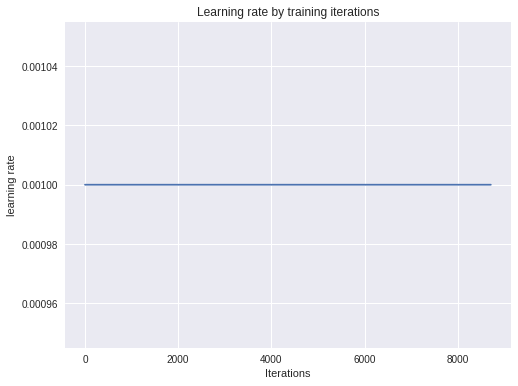

The execution took 3.0 hours | 30.0 minutes | 42.0 seconds!


In [0]:
run_utk(my_model, my_optimizer, epochs=300, log_interval=1, dataloaders=my_data_loaders,
        dirname='/content/checkpoints/sep_conv_adam', filename_prefix='sep_conv_adam', n_saved=1,
        log_dir=None, launch_tensorboard=False, patience=50,
        resume_model=None, resume_optimizer=None, backup_step=5, backup_path=backup_path,
        n_epochs_freeze=0, lr_after_freeze=None,
        loss_weights=[1/10, 1/0.16, 1/0.44])

### 3.2 Finetunig a pretrained Resnet50

We are going to :
* freeze all other layers and only train the classification using a learning rate of 1e-3
* unfreeze all layers after 10 epochs and finetune the whole model using a learning rate of 1e-4

In [0]:
backup_path = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/resnet_adam"
os.makedirs(backup_path, exist_ok=True)

In [0]:
my_model = PretrainedMT(model_name='resnet', feature_extract=True, use_pretrained=True)
my_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:05, 18020355.11it/s]


ITERATION - loss: 0.000:   0%|          | 0/130 [00:00<?, ?it/s]

Number of trainable parameters : 263,304
Number of non-trainable parameters : 23,508,032


ITERATION - loss: 6.230: 100%|██████████| 130/130 [01:42<00:00,  3.05it/s]

Training Results - Epoch: 1 Age L1-loss: 15.746 ** Gender accuracy: 0.766 ** Race accuracy: 0.615 ** Avg loss: 6.978


ITERATION - loss: 6.230: 100%|██████████| 130/130 [01:56<00:00,  3.05it/s]

Validation Results - Epoch: 1 Age L1-loss: 15.637 ** Gender accuracy: 0.749 ** Race accuracy: 0.598 ** Avg loss: 7.201


ITERATION - loss: 6.093: 100%|██████████| 130/130 [03:40<00:00,  3.05it/s]

Training Results - Epoch: 2 Age L1-loss: 15.535 ** Gender accuracy: 0.822 ** Race accuracy: 0.642 ** Avg loss: 6.197


ITERATION - loss: 6.093: 100%|██████████| 130/130 [03:54<00:00,  3.05it/s]

Validation Results - Epoch: 2 Age L1-loss: 15.436 ** Gender accuracy: 0.802 ** Race accuracy: 0.623 ** Avg loss: 6.481


ITERATION - loss: 6.312: 100%|██████████| 130/130 [05:38<00:00,  3.05it/s]

Training Results - Epoch: 3 Age L1-loss: 15.425 ** Gender accuracy: 0.806 ** Race accuracy: 0.656 ** Avg loss: 6.258


ITERATION - loss: 6.312: 100%|██████████| 130/130 [05:53<00:00,  3.05it/s]

Validation Results - Epoch: 3 Age L1-loss: 15.322 ** Gender accuracy: 0.782 ** Race accuracy: 0.631 ** Avg loss: 6.664


ITERATION - loss: 6.221: 100%|██████████| 130/130 [07:37<00:00,  3.05it/s]

Training Results - Epoch: 4 Age L1-loss: 15.333 ** Gender accuracy: 0.810 ** Race accuracy: 0.659 ** Avg loss: 6.212


ITERATION - loss: 6.221: 100%|██████████| 130/130 [07:51<00:00,  3.05it/s]

Validation Results - Epoch: 4 Age L1-loss: 15.237 ** Gender accuracy: 0.793 ** Race accuracy: 0.622 ** Avg loss: 6.600


ITERATION - loss: 6.989: 100%|██████████| 130/130 [09:35<00:00,  3.06it/s]

Training Results - Epoch: 5 Age L1-loss: 15.264 ** Gender accuracy: 0.831 ** Race accuracy: 0.669 ** Avg loss: 5.890


ITERATION - loss: 6.989: 100%|██████████| 130/130 [09:49<00:00,  3.06it/s]

Validation Results - Epoch: 5 Age L1-loss: 15.174 ** Gender accuracy: 0.809 ** Race accuracy: 0.634 ** Avg loss: 6.288


ITERATION - loss: 5.762: 100%|██████████| 130/130 [11:35<00:00,  3.04it/s]

Training Results - Epoch: 6 Age L1-loss: 15.214 ** Gender accuracy: 0.780 ** Race accuracy: 0.666 ** Avg loss: 6.468


ITERATION - loss: 5.762: 100%|██████████| 130/130 [11:49<00:00,  3.04it/s]

Validation Results - Epoch: 6 Age L1-loss: 15.113 ** Gender accuracy: 0.758 ** Race accuracy: 0.633 ** Avg loss: 6.972


ITERATION - loss: 5.546: 100%|██████████| 130/130 [13:34<00:00,  3.05it/s]

Training Results - Epoch: 7 Age L1-loss: 15.192 ** Gender accuracy: 0.840 ** Race accuracy: 0.660 ** Avg loss: 5.900


ITERATION - loss: 5.546: 100%|██████████| 130/130 [13:48<00:00,  3.05it/s]

Validation Results - Epoch: 7 Age L1-loss: 15.106 ** Gender accuracy: 0.813 ** Race accuracy: 0.628 ** Avg loss: 6.385


ITERATION - loss: 6.393: 100%|██████████| 130/130 [15:33<00:00,  3.04it/s]

Training Results - Epoch: 8 Age L1-loss: 15.162 ** Gender accuracy: 0.830 ** Race accuracy: 0.690 ** Avg loss: 5.813


ITERATION - loss: 6.393: 100%|██████████| 130/130 [15:48<00:00,  3.04it/s]

Validation Results - Epoch: 8 Age L1-loss: 15.071 ** Gender accuracy: 0.801 ** Race accuracy: 0.652 ** Avg loss: 6.359


ITERATION - loss: 5.998: 100%|██████████| 130/130 [17:34<00:00,  3.05it/s]

Training Results - Epoch: 9 Age L1-loss: 15.198 ** Gender accuracy: 0.844 ** Race accuracy: 0.687 ** Avg loss: 5.674


ITERATION - loss: 5.998: 100%|██████████| 130/130 [17:49<00:00,  3.05it/s]

Validation Results - Epoch: 9 Age L1-loss: 15.129 ** Gender accuracy: 0.815 ** Race accuracy: 0.643 ** Avg loss: 6.204
****Unfreezing frozen layers ... ***
Number of trainable parameters : 23,771,336
Number of non-trainable parameters : 0


ITERATION - loss: 4.946: 100%|██████████| 130/130 [21:21<00:00,  1.07s/it]

Training Results - Epoch: 10 Age L1-loss: 15.090 ** Gender accuracy: 0.965 ** Race accuracy: 0.865 ** Avg loss: 3.047


ITERATION - loss: 4.946: 100%|██████████| 130/130 [21:35<00:00,  1.07s/it]

Validation Results - Epoch: 10 Age L1-loss: 15.008 ** Gender accuracy: 0.915 ** Race accuracy: 0.786 ** Avg loss: 4.276


ITERATION - loss: 2.955: 100%|██████████| 130/130 [25:08<00:00,  1.07s/it]

Training Results - Epoch: 11 Age L1-loss: 15.052 ** Gender accuracy: 0.976 ** Race accuracy: 0.911 ** Avg loss: 2.521


ITERATION - loss: 2.955: 100%|██████████| 130/130 [25:21<00:00,  1.07s/it]

Validation Results - Epoch: 11 Age L1-loss: 14.942 ** Gender accuracy: 0.901 ** Race accuracy: 0.781 ** Avg loss: 4.861


ITERATION - loss: 3.235: 100%|██████████| 130/130 [28:51<00:00,  1.07s/it]

Training Results - Epoch: 12 Age L1-loss: 15.044 ** Gender accuracy: 0.982 ** Race accuracy: 0.943 ** Avg loss: 2.200


ITERATION - loss: 3.235: 100%|██████████| 130/130 [29:05<00:00,  1.07s/it]

Validation Results - Epoch: 12 Age L1-loss: 14.934 ** Gender accuracy: 0.904 ** Race accuracy: 0.792 ** Avg loss: 5.271


ITERATION - loss: 2.395: 100%|██████████| 130/130 [32:36<00:00,  1.07s/it]

Training Results - Epoch: 13 Age L1-loss: 15.049 ** Gender accuracy: 0.977 ** Race accuracy: 0.963 ** Avg loss: 2.119


ITERATION - loss: 2.395: 100%|██████████| 130/130 [32:49<00:00,  1.07s/it]

Validation Results - Epoch: 13 Age L1-loss: 14.945 ** Gender accuracy: 0.900 ** Race accuracy: 0.775 ** Avg loss: 5.893


ITERATION - loss: 1.885: 100%|██████████| 130/130 [36:19<00:00,  1.07s/it]

Training Results - Epoch: 14 Age L1-loss: 15.183 ** Gender accuracy: 0.991 ** Race accuracy: 0.954 ** Avg loss: 1.998


ITERATION - loss: 1.885: 100%|██████████| 130/130 [36:32<00:00,  1.07s/it]

Validation Results - Epoch: 14 Age L1-loss: 15.102 ** Gender accuracy: 0.909 ** Race accuracy: 0.781 ** Avg loss: 6.417


ITERATION - loss: 2.335: 100%|██████████| 130/130 [40:02<00:00,  1.07s/it]

Training Results - Epoch: 15 Age L1-loss: 15.032 ** Gender accuracy: 0.993 ** Race accuracy: 0.985 ** Avg loss: 1.746


ITERATION - loss: 2.335: 100%|██████████| 130/130 [40:15<00:00,  1.07s/it]

Validation Results - Epoch: 15 Age L1-loss: 14.926 ** Gender accuracy: 0.915 ** Race accuracy: 0.803 ** Avg loss: 5.865


ITERATION - loss: 1.877: 100%|██████████| 130/130 [43:46<00:00,  1.07s/it]

Training Results - Epoch: 16 Age L1-loss: 15.035 ** Gender accuracy: 0.991 ** Race accuracy: 0.980 ** Avg loss: 1.763


ITERATION - loss: 1.877: 100%|██████████| 130/130 [44:00<00:00,  1.07s/it]

Validation Results - Epoch: 16 Age L1-loss: 14.937 ** Gender accuracy: 0.904 ** Race accuracy: 0.806 ** Avg loss: 6.852


ITERATION - loss: 2.123: 100%|██████████| 130/130 [47:29<00:00,  1.06s/it]

Training Results - Epoch: 17 Age L1-loss: 15.073 ** Gender accuracy: 0.994 ** Race accuracy: 0.987 ** Avg loss: 1.693


ITERATION - loss: 2.123: 100%|██████████| 130/130 [47:42<00:00,  1.06s/it]

Validation Results - Epoch: 17 Age L1-loss: 14.948 ** Gender accuracy: 0.919 ** Race accuracy: 0.799 ** Avg loss: 6.312


ITERATION - loss: 1.658: 100%|██████████| 130/130 [51:11<00:00,  1.06s/it]

Training Results - Epoch: 18 Age L1-loss: 15.303 ** Gender accuracy: 0.989 ** Race accuracy: 0.983 ** Avg loss: 1.826


ITERATION - loss: 1.658: 100%|██████████| 130/130 [51:25<00:00,  1.06s/it]

Validation Results - Epoch: 18 Age L1-loss: 15.148 ** Gender accuracy: 0.911 ** Race accuracy: 0.796 ** Avg loss: 6.311


ITERATION - loss: 2.469: 100%|██████████| 130/130 [54:55<00:00,  1.07s/it]

Training Results - Epoch: 19 Age L1-loss: 15.125 ** Gender accuracy: 0.990 ** Race accuracy: 0.948 ** Avg loss: 2.074


ITERATION - loss: 2.469: 100%|██████████| 130/130 [55:08<00:00,  1.07s/it]

Validation Results - Epoch: 19 Age L1-loss: 15.044 ** Gender accuracy: 0.913 ** Race accuracy: 0.777 ** Avg loss: 6.876


ITERATION - loss: 1.640: 100%|██████████| 130/130 [58:39<00:00,  1.06s/it]

Training Results - Epoch: 20 Age L1-loss: 15.182 ** Gender accuracy: 0.996 ** Race accuracy: 0.981 ** Avg loss: 1.709


ITERATION - loss: 1.640: 100%|██████████| 130/130 [58:52<00:00,  1.06s/it]

Validation Results - Epoch: 20 Age L1-loss: 15.032 ** Gender accuracy: 0.926 ** Race accuracy: 0.793 ** Avg loss: 6.356


ITERATION - loss: 1.853: 100%|██████████| 130/130 [1:02:23<00:00,  1.07s/it]

Training Results - Epoch: 21 Age L1-loss: 15.021 ** Gender accuracy: 0.996 ** Race accuracy: 0.983 ** Avg loss: 1.692


ITERATION - loss: 1.853: 100%|██████████| 130/130 [1:02:37<00:00,  1.07s/it]

Validation Results - Epoch: 21 Age L1-loss: 14.919 ** Gender accuracy: 0.919 ** Race accuracy: 0.811 ** Avg loss: 6.508


ITERATION - loss: 2.145: 100%|██████████| 130/130 [1:06:08<00:00,  1.07s/it]

Training Results - Epoch: 22 Age L1-loss: 15.200 ** Gender accuracy: 0.989 ** Race accuracy: 0.966 ** Avg loss: 1.919


ITERATION - loss: 2.145: 100%|██████████| 130/130 [1:06:21<00:00,  1.07s/it]

Validation Results - Epoch: 22 Age L1-loss: 15.129 ** Gender accuracy: 0.912 ** Race accuracy: 0.789 ** Avg loss: 6.666


ITERATION - loss: 1.747: 100%|██████████| 130/130 [1:09:53<00:00,  1.08s/it]

Training Results - Epoch: 23 Age L1-loss: 15.066 ** Gender accuracy: 0.997 ** Race accuracy: 0.989 ** Avg loss: 1.628


ITERATION - loss: 1.747: 100%|██████████| 130/130 [1:10:06<00:00,  1.08s/it]

Validation Results - Epoch: 23 Age L1-loss: 14.975 ** Gender accuracy: 0.922 ** Race accuracy: 0.805 ** Avg loss: 6.545


ITERATION - loss: 1.898: 100%|██████████| 130/130 [1:13:37<00:00,  1.07s/it]

Training Results - Epoch: 24 Age L1-loss: 15.021 ** Gender accuracy: 0.995 ** Race accuracy: 0.974 ** Avg loss: 1.767


ITERATION - loss: 1.898: 100%|██████████| 130/130 [1:13:50<00:00,  1.07s/it]

Validation Results - Epoch: 24 Age L1-loss: 14.916 ** Gender accuracy: 0.909 ** Race accuracy: 0.787 ** Avg loss: 6.800


ITERATION - loss: 1.898: 100%|██████████| 130/130 [1:17:19<00:00,  1.07s/it]

Training Results - Epoch: 25 Age L1-loss: 15.029 ** Gender accuracy: 0.997 ** Race accuracy: 0.992 ** Avg loss: 1.598


ITERATION - loss: 1.898: 100%|██████████| 130/130 [1:17:33<00:00,  1.07s/it]

Validation Results - Epoch: 25 Age L1-loss: 14.925 ** Gender accuracy: 0.917 ** Race accuracy: 0.807 ** Avg loss: 6.633


ITERATION - loss: 2.138: 100%|██████████| 130/130 [1:21:03<00:00,  1.06s/it]

Training Results - Epoch: 26 Age L1-loss: 15.013 ** Gender accuracy: 0.993 ** Race accuracy: 0.928 ** Avg loss: 2.251


ITERATION - loss: 2.138: 100%|██████████| 130/130 [1:21:16<00:00,  1.06s/it]

Validation Results - Epoch: 26 Age L1-loss: 14.905 ** Gender accuracy: 0.908 ** Race accuracy: 0.760 ** Avg loss: 8.684


ITERATION - loss: 1.746: 100%|██████████| 130/130 [1:24:45<00:00,  1.06s/it]

Training Results - Epoch: 27 Age L1-loss: 15.144 ** Gender accuracy: 0.996 ** Race accuracy: 0.981 ** Avg loss: 1.711


ITERATION - loss: 1.746: 100%|██████████| 130/130 [1:24:59<00:00,  1.06s/it]

Validation Results - Epoch: 27 Age L1-loss: 15.064 ** Gender accuracy: 0.917 ** Race accuracy: 0.801 ** Avg loss: 7.580


ITERATION - loss: 1.899: 100%|██████████| 130/130 [1:28:28<00:00,  1.08s/it]

Training Results - Epoch: 28 Age L1-loss: 15.013 ** Gender accuracy: 0.997 ** Race accuracy: 0.990 ** Avg loss: 1.617


ITERATION - loss: 1.899: 100%|██████████| 130/130 [1:28:41<00:00,  1.08s/it]

Validation Results - Epoch: 28 Age L1-loss: 14.909 ** Gender accuracy: 0.914 ** Race accuracy: 0.803 ** Avg loss: 7.586


ITERATION - loss: 1.813: 100%|██████████| 130/130 [1:32:11<00:00,  1.07s/it]

Training Results - Epoch: 29 Age L1-loss: 15.448 ** Gender accuracy: 0.998 ** Race accuracy: 0.987 ** Avg loss: 1.670


ITERATION - loss: 1.813: 100%|██████████| 130/130 [1:32:24<00:00,  1.07s/it]

Validation Results - Epoch: 29 Age L1-loss: 15.378 ** Gender accuracy: 0.921 ** Race accuracy: 0.796 ** Avg loss: 7.049


ITERATION - loss: 1.815: 100%|██████████| 130/130 [1:35:54<00:00,  1.07s/it]

Training Results - Epoch: 30 Age L1-loss: 15.016 ** Gender accuracy: 0.998 ** Race accuracy: 0.991 ** Avg loss: 1.585


ITERATION - loss: 1.815: 100%|██████████| 130/130 [1:36:08<00:00,  1.07s/it]

Validation Results - Epoch: 30 Age L1-loss: 14.913 ** Gender accuracy: 0.918 ** Race accuracy: 0.808 ** Avg loss: 7.282


ITERATION - loss: 1.490: 100%|██████████| 130/130 [1:39:41<00:00,  1.08s/it]

Training Results - Epoch: 31 Age L1-loss: 15.019 ** Gender accuracy: 0.998 ** Race accuracy: 0.995 ** Avg loss: 1.564


ITERATION - loss: 1.490: 100%|██████████| 130/130 [1:39:54<00:00,  1.08s/it]

Validation Results - Epoch: 31 Age L1-loss: 14.903 ** Gender accuracy: 0.916 ** Race accuracy: 0.813 ** Avg loss: 7.831


ITERATION - loss: 1.456: 100%|██████████| 130/130 [1:43:26<00:00,  1.08s/it]

Training Results - Epoch: 32 Age L1-loss: 15.171 ** Gender accuracy: 0.989 ** Race accuracy: 0.978 ** Avg loss: 1.879


ITERATION - loss: 1.456: 100%|██████████| 130/130 [1:43:39<00:00,  1.08s/it]

Validation Results - Epoch: 32 Age L1-loss: 15.097 ** Gender accuracy: 0.903 ** Race accuracy: 0.785 ** Avg loss: 8.416


ITERATION - loss: 1.850: 100%|██████████| 130/130 [1:47:09<00:00,  1.07s/it]

Training Results - Epoch: 33 Age L1-loss: 15.427 ** Gender accuracy: 0.997 ** Race accuracy: 0.989 ** Avg loss: 1.656


ITERATION - loss: 1.850: 100%|██████████| 130/130 [1:47:22<00:00,  1.07s/it]

Validation Results - Epoch: 33 Age L1-loss: 15.360 ** Gender accuracy: 0.918 ** Race accuracy: 0.805 ** Avg loss: 7.160


ITERATION - loss: 1.586: 100%|██████████| 130/130 [1:50:53<00:00,  1.07s/it]

Training Results - Epoch: 34 Age L1-loss: 15.059 ** Gender accuracy: 0.992 ** Race accuracy: 0.974 ** Avg loss: 1.837


ITERATION - loss: 1.586: 100%|██████████| 130/130 [1:51:06<00:00,  1.07s/it]

Validation Results - Epoch: 34 Age L1-loss: 14.970 ** Gender accuracy: 0.913 ** Race accuracy: 0.801 ** Avg loss: 7.740


ITERATION - loss: 1.788: 100%|██████████| 130/130 [1:54:36<00:00,  1.07s/it]

Training Results - Epoch: 35 Age L1-loss: 15.111 ** Gender accuracy: 0.994 ** Race accuracy: 0.979 ** Avg loss: 1.754


ITERATION - loss: 1.788: 100%|██████████| 130/130 [1:54:49<00:00,  1.07s/it]

Validation Results - Epoch: 35 Age L1-loss: 15.035 ** Gender accuracy: 0.913 ** Race accuracy: 0.801 ** Avg loss: 7.291


ITERATION - loss: 1.564: 100%|██████████| 130/130 [1:58:21<00:00,  1.07s/it]

Training Results - Epoch: 36 Age L1-loss: 15.022 ** Gender accuracy: 0.996 ** Race accuracy: 0.992 ** Avg loss: 1.606


ITERATION - loss: 1.564: 100%|██████████| 130/130 [1:58:34<00:00,  1.07s/it]

Validation Results - Epoch: 36 Age L1-loss: 14.925 ** Gender accuracy: 0.919 ** Race accuracy: 0.801 ** Avg loss: 7.436


ITERATION - loss: 1.587: 100%|██████████| 130/130 [2:02:05<00:00,  1.07s/it]

Training Results - Epoch: 37 Age L1-loss: 15.013 ** Gender accuracy: 0.998 ** Race accuracy: 0.991 ** Avg loss: 1.586


ITERATION - loss: 1.587: 100%|██████████| 130/130 [2:02:18<00:00,  1.07s/it]

Validation Results - Epoch: 37 Age L1-loss: 14.908 ** Gender accuracy: 0.925 ** Race accuracy: 0.814 ** Avg loss: 7.165


ITERATION - loss: 1.637: 100%|██████████| 130/130 [2:05:48<00:00,  1.07s/it]

Training Results - Epoch: 38 Age L1-loss: 15.024 ** Gender accuracy: 0.997 ** Race accuracy: 0.993 ** Avg loss: 1.600


ITERATION - loss: 1.637: 100%|██████████| 130/130 [2:06:02<00:00,  1.07s/it]

Validation Results - Epoch: 38 Age L1-loss: 14.903 ** Gender accuracy: 0.919 ** Race accuracy: 0.806 ** Avg loss: 7.429


ITERATION - loss: 1.992: 100%|██████████| 130/130 [2:09:31<00:00,  1.07s/it]

Training Results - Epoch: 39 Age L1-loss: 15.012 ** Gender accuracy: 0.993 ** Race accuracy: 0.986 ** Avg loss: 1.712


ITERATION - loss: 1.992: 100%|██████████| 130/130 [2:09:45<00:00,  1.07s/it]

Validation Results - Epoch: 39 Age L1-loss: 14.910 ** Gender accuracy: 0.911 ** Race accuracy: 0.808 ** Avg loss: 7.024


ITERATION - loss: 1.815: 100%|██████████| 130/130 [2:13:16<00:00,  1.08s/it]

Training Results - Epoch: 40 Age L1-loss: 15.045 ** Gender accuracy: 0.998 ** Race accuracy: 0.986 ** Avg loss: 1.634


ITERATION - loss: 1.815: 100%|██████████| 130/130 [2:13:30<00:00,  1.08s/it]

Validation Results - Epoch: 40 Age L1-loss: 14.949 ** Gender accuracy: 0.922 ** Race accuracy: 0.804 ** Avg loss: 7.191


ITERATION - loss: 1.890: 100%|██████████| 130/130 [2:17:02<00:00,  1.07s/it]

Training Results - Epoch: 41 Age L1-loss: 15.048 ** Gender accuracy: 0.998 ** Race accuracy: 0.996 ** Avg loss: 1.562


ITERATION - loss: 1.890: 100%|██████████| 130/130 [2:17:16<00:00,  1.07s/it]

Validation Results - Epoch: 41 Age L1-loss: 14.921 ** Gender accuracy: 0.920 ** Race accuracy: 0.820 ** Avg loss: 6.882


ITERATION - loss: 1.669: 100%|██████████| 130/130 [2:20:46<00:00,  1.07s/it]

Training Results - Epoch: 42 Age L1-loss: 15.048 ** Gender accuracy: 0.998 ** Race accuracy: 0.993 ** Avg loss: 1.575


ITERATION - loss: 1.669: 100%|██████████| 130/130 [2:21:00<00:00,  1.07s/it]

Validation Results - Epoch: 42 Age L1-loss: 14.954 ** Gender accuracy: 0.923 ** Race accuracy: 0.807 ** Avg loss: 7.299


ITERATION - loss: 1.819: 100%|██████████| 130/130 [2:24:31<00:00,  1.07s/it]

Training Results - Epoch: 43 Age L1-loss: 15.052 ** Gender accuracy: 0.997 ** Race accuracy: 0.994 ** Avg loss: 1.594


ITERATION - loss: 1.819: 100%|██████████| 130/130 [2:24:44<00:00,  1.07s/it]

Validation Results - Epoch: 43 Age L1-loss: 14.953 ** Gender accuracy: 0.913 ** Race accuracy: 0.807 ** Avg loss: 7.272


ITERATION - loss: 1.649: 100%|██████████| 130/130 [2:28:15<00:00,  1.07s/it]

Training Results - Epoch: 44 Age L1-loss: 15.042 ** Gender accuracy: 0.997 ** Race accuracy: 0.994 ** Avg loss: 1.587


ITERATION - loss: 1.649: 100%|██████████| 130/130 [2:28:29<00:00,  1.07s/it]

Validation Results - Epoch: 44 Age L1-loss: 14.940 ** Gender accuracy: 0.922 ** Race accuracy: 0.811 ** Avg loss: 7.256


ITERATION - loss: 1.485: 100%|██████████| 130/130 [2:31:59<00:00,  1.07s/it]

Training Results - Epoch: 45 Age L1-loss: 15.051 ** Gender accuracy: 0.998 ** Race accuracy: 0.987 ** Avg loss: 1.612


ITERATION - loss: 1.485: 100%|██████████| 130/130 [2:32:12<00:00,  1.07s/it]

Validation Results - Epoch: 45 Age L1-loss: 14.920 ** Gender accuracy: 0.927 ** Race accuracy: 0.800 ** Avg loss: 8.209


ITERATION - loss: 1.688: 100%|██████████| 130/130 [2:35:44<00:00,  1.07s/it]

Training Results - Epoch: 46 Age L1-loss: 15.168 ** Gender accuracy: 0.996 ** Race accuracy: 0.993 ** Avg loss: 1.630


ITERATION - loss: 1.688: 100%|██████████| 130/130 [2:35:57<00:00,  1.07s/it]

Validation Results - Epoch: 46 Age L1-loss: 15.085 ** Gender accuracy: 0.923 ** Race accuracy: 0.812 ** Avg loss: 7.659


ITERATION - loss: 1.470: 100%|██████████| 130/130 [2:39:27<00:00,  1.07s/it]

Training Results - Epoch: 47 Age L1-loss: 15.061 ** Gender accuracy: 0.995 ** Race accuracy: 0.992 ** Avg loss: 1.660


ITERATION - loss: 1.470: 100%|██████████| 130/130 [2:39:40<00:00,  1.07s/it]

Validation Results - Epoch: 47 Age L1-loss: 14.924 ** Gender accuracy: 0.923 ** Race accuracy: 0.809 ** Avg loss: 7.250


ITERATION - loss: 2.362: 100%|██████████| 130/130 [2:43:09<00:00,  1.07s/it]

Training Results - Epoch: 48 Age L1-loss: 15.129 ** Gender accuracy: 0.989 ** Race accuracy: 0.986 ** Avg loss: 1.824


ITERATION - loss: 2.362: 100%|██████████| 130/130 [2:43:22<00:00,  1.07s/it]

Validation Results - Epoch: 48 Age L1-loss: 14.975 ** Gender accuracy: 0.909 ** Race accuracy: 0.817 ** Avg loss: 7.714


ITERATION - loss: 1.751: 100%|██████████| 130/130 [2:46:52<00:00,  1.07s/it]

Training Results - Epoch: 49 Age L1-loss: 15.031 ** Gender accuracy: 0.998 ** Race accuracy: 0.986 ** Avg loss: 1.613


ITERATION - loss: 1.751: 100%|██████████| 130/130 [2:47:05<00:00,  1.07s/it]

Validation Results - Epoch: 49 Age L1-loss: 14.937 ** Gender accuracy: 0.928 ** Race accuracy: 0.808 ** Avg loss: 6.863


ITERATION - loss: 1.549: 100%|██████████| 130/130 [2:50:35<00:00,  1.08s/it]

Training Results - Epoch: 50 Age L1-loss: 15.110 ** Gender accuracy: 0.998 ** Race accuracy: 0.993 ** Avg loss: 1.575


ITERATION - loss: 1.549: 100%|██████████| 130/130 [2:50:48<00:00,  1.08s/it]

Validation Results - Epoch: 50 Age L1-loss: 15.023 ** Gender accuracy: 0.920 ** Race accuracy: 0.814 ** Avg loss: 7.241


ITERATION - loss: 1.583: 100%|██████████| 130/130 [2:54:21<00:00,  1.07s/it]

Training Results - Epoch: 51 Age L1-loss: 15.064 ** Gender accuracy: 0.997 ** Race accuracy: 0.989 ** Avg loss: 1.631


ITERATION - loss: 1.583: 100%|██████████| 130/130 [2:54:35<00:00,  1.07s/it]

Validation Results - Epoch: 51 Age L1-loss: 14.927 ** Gender accuracy: 0.916 ** Race accuracy: 0.807 ** Avg loss: 7.241


ITERATION - loss: 1.779: 100%|██████████| 130/130 [2:58:06<00:00,  1.07s/it]

Training Results - Epoch: 52 Age L1-loss: 15.013 ** Gender accuracy: 0.998 ** Race accuracy: 0.992 ** Avg loss: 1.580


ITERATION - loss: 1.779: 100%|██████████| 130/130 [2:58:20<00:00,  1.07s/it]

Validation Results - Epoch: 52 Age L1-loss: 14.909 ** Gender accuracy: 0.915 ** Race accuracy: 0.810 ** Avg loss: 7.896


ITERATION - loss: 1.948: 100%|██████████| 130/130 [3:01:50<00:00,  1.07s/it]

Training Results - Epoch: 53 Age L1-loss: 15.015 ** Gender accuracy: 0.999 ** Race accuracy: 0.997 ** Avg loss: 1.538


ITERATION - loss: 1.948: 100%|██████████| 130/130 [3:02:03<00:00,  1.07s/it]

Validation Results - Epoch: 53 Age L1-loss: 14.901 ** Gender accuracy: 0.927 ** Race accuracy: 0.821 ** Avg loss: 6.944


ITERATION - loss: 1.575: 100%|██████████| 130/130 [3:05:34<00:00,  1.07s/it]

Training Results - Epoch: 54 Age L1-loss: 15.036 ** Gender accuracy: 0.999 ** Race accuracy: 0.996 ** Avg loss: 1.538


ITERATION - loss: 1.575: 100%|██████████| 130/130 [3:05:47<00:00,  1.07s/it]

Validation Results - Epoch: 54 Age L1-loss: 14.947 ** Gender accuracy: 0.924 ** Race accuracy: 0.815 ** Avg loss: 7.518


ITERATION - loss: 1.729: 100%|██████████| 130/130 [3:09:17<00:00,  1.07s/it]

Training Results - Epoch: 55 Age L1-loss: 15.011 ** Gender accuracy: 0.999 ** Race accuracy: 0.997 ** Avg loss: 1.531


ITERATION - loss: 1.729: 100%|██████████| 130/130 [3:09:30<00:00,  1.07s/it]

Validation Results - Epoch: 55 Age L1-loss: 14.905 ** Gender accuracy: 0.924 ** Race accuracy: 0.819 ** Avg loss: 7.692


ITERATION - loss: 1.487: 100%|██████████| 130/130 [3:13:02<00:00,  1.07s/it]

Training Results - Epoch: 56 Age L1-loss: 15.015 ** Gender accuracy: 0.997 ** Race accuracy: 0.991 ** Avg loss: 1.601


ITERATION - loss: 1.487: 100%|██████████| 130/130 [3:13:15<00:00,  1.07s/it]

Validation Results - Epoch: 56 Age L1-loss: 14.907 ** Gender accuracy: 0.916 ** Race accuracy: 0.823 ** Avg loss: 8.535


ITERATION - loss: 1.952: 100%|██████████| 130/130 [3:16:45<00:00,  1.07s/it]

Training Results - Epoch: 57 Age L1-loss: 15.040 ** Gender accuracy: 0.996 ** Race accuracy: 0.980 ** Avg loss: 1.720


ITERATION - loss: 1.952: 100%|██████████| 130/130 [3:16:58<00:00,  1.07s/it]

Validation Results - Epoch: 57 Age L1-loss: 14.945 ** Gender accuracy: 0.915 ** Race accuracy: 0.804 ** Avg loss: 7.286


ITERATION - loss: 2.430: 100%|██████████| 130/130 [3:20:28<00:00,  1.07s/it]

Training Results - Epoch: 58 Age L1-loss: 15.299 ** Gender accuracy: 0.997 ** Race accuracy: 0.974 ** Avg loss: 1.798


ITERATION - loss: 2.430: 100%|██████████| 130/130 [3:20:41<00:00,  1.07s/it]

Validation Results - Epoch: 58 Age L1-loss: 15.209 ** Gender accuracy: 0.923 ** Race accuracy: 0.784 ** Avg loss: 7.614


ITERATION - loss: 1.758: 100%|██████████| 130/130 [3:24:12<00:00,  1.07s/it]

Training Results - Epoch: 59 Age L1-loss: 15.078 ** Gender accuracy: 0.996 ** Race accuracy: 0.990 ** Avg loss: 1.633


ITERATION - loss: 1.758: 100%|██████████| 130/130 [3:24:25<00:00,  1.07s/it]

Validation Results - Epoch: 59 Age L1-loss: 14.935 ** Gender accuracy: 0.921 ** Race accuracy: 0.804 ** Avg loss: 7.677


ITERATION - loss: 2.063: 100%|██████████| 130/130 [3:27:55<00:00,  1.07s/it]

Training Results - Epoch: 60 Age L1-loss: 15.106 ** Gender accuracy: 0.996 ** Race accuracy: 0.989 ** Avg loss: 1.639


ITERATION - loss: 2.063: 100%|██████████| 130/130 [3:28:08<00:00,  1.07s/it]

Validation Results - Epoch: 60 Age L1-loss: 15.011 ** Gender accuracy: 0.924 ** Race accuracy: 0.808 ** Avg loss: 6.503


ITERATION - loss: 1.479: 100%|██████████| 130/130 [3:31:42<00:00,  1.07s/it]

Training Results - Epoch: 61 Age L1-loss: 15.013 ** Gender accuracy: 0.997 ** Race accuracy: 0.994 ** Avg loss: 1.589


ITERATION - loss: 1.479: 100%|██████████| 130/130 [3:31:55<00:00,  1.07s/it]

Validation Results - Epoch: 61 Age L1-loss: 14.911 ** Gender accuracy: 0.922 ** Race accuracy: 0.817 ** Avg loss: 6.650


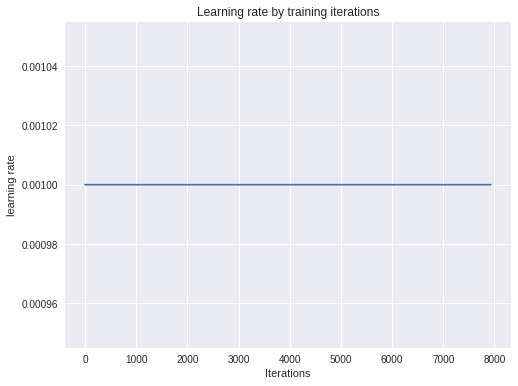

The execution took 3.0 hours | 31.0 minutes | 57.5 seconds!


In [0]:
run_utk(my_model, my_optimizer, epochs=300, log_interval=1, dataloaders=my_data_loaders,
        dirname='/content/checkpoints/resnet_adam', filename_prefix='resnet', n_saved=1,
        log_dir='/content/logs', launch_tensorboard=False, patience=50,
        resume_model=None, resume_optimizer=None, backup_step=5, backup_path=backup_path,
        n_epochs_freeze=10, n_cycle=None, lr_after_freeze=1e-4,
        loss_weights=[1/10, 1/0.16, 1/0.44], lr_plot=True)

### 3.3 Finetuning a pretrained VGG19

In [0]:
backup_path = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/vgg_adam"
os.makedirs(backup_path, exist_ok=True)

In [0]:

my_model = PretrainedMT(model_name='vgg', feature_extract=True, use_pretrained=True)
my_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()), lr=1e-3)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:06, 83291644.09it/s]


In [0]:
run_utk(my_model, my_optimizer, epochs=300, log_interval=1, dataloaders=my_data_loaders,
        dirname='/content/checkpoints/vgg_adam', filename_prefix='vgg', n_saved=1,
        log_dir='/content/logs', launch_tensorboard=False, patience=50,
        resume_model=None, resume_optimizer=None, backup_step=5, backup_path=backup_path,
        n_epochs_freeze=10, n_cycle=None, lr_after_freeze=1e-4,
        loss_weights=[1/10, 1/0.16, 1/0.44], lr_plot=True)


ITERATION - loss: 0.000:   0%|          | 0/130 [00:00<?, ?it/s]

Number of trainable parameters : 525,448
Number of non-trainable parameters : 139,581,248



ITERATION - loss: 6.304: 100%|██████████| 130/130 [02:48<00:00,  1.17s/it]

ITERATION - loss: 6.304: 100%|██████████| 130/130 [05:35<00:00,  1.17s/it]

Training Results - Epoch: 1 Age L1-loss: 15.653 ** Gender accuracy: 0.782 ** Race accuracy: 0.605 ** Avg loss: 6.787



ITERATION - loss: 6.304: 100%|██████████| 130/130 [06:13<00:00,  1.17s/it]

Validation Results - Epoch: 1 Age L1-loss: 15.503 ** Gender accuracy: 0.775 ** Race accuracy: 0.575 ** Avg loss: 7.002



ITERATION - loss: 6.455: 100%|██████████| 130/130 [09:02<00:00,  1.17s/it]

ITERATION - loss: 6.455: 100%|██████████| 130/130 [11:47<00:00,  1.17s/it]

Training Results - Epoch: 2 Age L1-loss: 15.590 ** Gender accuracy: 0.822 ** Race accuracy: 0.629 ** Avg loss: 6.313



ITERATION - loss: 6.455: 100%|██████████| 130/130 [12:25<00:00,  1.17s/it]

Validation Results - Epoch: 2 Age L1-loss: 15.451 ** Gender accuracy: 0.810 ** Race accuracy: 0.599 ** Avg loss: 6.573



ITERATION - loss: 7.612: 100%|██████████| 130/130 [15:14<00:00,  1.17s/it]

ITERATION - loss: 7.612: 100%|██████████| 130/130 [18:02<00:00,  1.17s/it]

Training Results - Epoch: 3 Age L1-loss: 15.476 ** Gender accuracy: 0.821 ** Race accuracy: 0.631 ** Avg loss: 6.273



ITERATION - loss: 7.612: 100%|██████████| 130/130 [18:40<00:00,  1.17s/it]

Validation Results - Epoch: 3 Age L1-loss: 15.344 ** Gender accuracy: 0.803 ** Race accuracy: 0.605 ** Avg loss: 6.596



ITERATION - loss: 6.437: 100%|██████████| 130/130 [21:29<00:00,  1.17s/it]

ITERATION - loss: 6.437: 100%|██████████| 130/130 [24:14<00:00,  1.17s/it]

Training Results - Epoch: 4 Age L1-loss: 15.347 ** Gender accuracy: 0.820 ** Race accuracy: 0.648 ** Avg loss: 6.194



ITERATION - loss: 6.437: 100%|██████████| 130/130 [24:52<00:00,  1.17s/it]

Validation Results - Epoch: 4 Age L1-loss: 15.235 ** Gender accuracy: 0.808 ** Race accuracy: 0.606 ** Avg loss: 6.510



ITERATION - loss: 6.872: 100%|██████████| 130/130 [27:40<00:00,  1.16s/it]

ITERATION - loss: 6.872: 100%|██████████| 130/130 [30:28<00:00,  1.16s/it]

Training Results - Epoch: 5 Age L1-loss: 15.369 ** Gender accuracy: 0.826 ** Race accuracy: 0.648 ** Avg loss: 6.133



ITERATION - loss: 6.872: 100%|██████████| 130/130 [31:05<00:00,  1.16s/it]

Validation Results - Epoch: 5 Age L1-loss: 15.244 ** Gender accuracy: 0.810 ** Race accuracy: 0.612 ** Avg loss: 6.464



ITERATION - loss: 6.914: 100%|██████████| 130/130 [33:57<00:00,  1.17s/it]

ITERATION - loss: 6.914: 100%|██████████| 130/130 [36:45<00:00,  1.17s/it]

Training Results - Epoch: 6 Age L1-loss: 16.008 ** Gender accuracy: 0.825 ** Race accuracy: 0.652 ** Avg loss: 6.188



ITERATION - loss: 6.914: 100%|██████████| 130/130 [37:23<00:00,  1.17s/it]

Validation Results - Epoch: 6 Age L1-loss: 15.827 ** Gender accuracy: 0.808 ** Race accuracy: 0.617 ** Avg loss: 6.520



ITERATION - loss: 7.624: 100%|██████████| 130/130 [40:11<00:00,  1.17s/it]

ITERATION - loss: 7.624: 100%|██████████| 130/130 [42:56<00:00,  1.17s/it]

Training Results - Epoch: 7 Age L1-loss: 15.249 ** Gender accuracy: 0.827 ** Race accuracy: 0.646 ** Avg loss: 6.134



ITERATION - loss: 7.624: 100%|██████████| 130/130 [43:33<00:00,  1.17s/it]

Validation Results - Epoch: 7 Age L1-loss: 15.155 ** Gender accuracy: 0.812 ** Race accuracy: 0.607 ** Avg loss: 6.479



ITERATION - loss: 7.163: 100%|██████████| 130/130 [46:22<00:00,  1.17s/it]

ITERATION - loss: 7.163: 100%|██████████| 130/130 [49:07<00:00,  1.17s/it]

Training Results - Epoch: 8 Age L1-loss: 15.627 ** Gender accuracy: 0.820 ** Race accuracy: 0.650 ** Avg loss: 6.163



ITERATION - loss: 7.163: 100%|██████████| 130/130 [49:45<00:00,  1.17s/it]

Validation Results - Epoch: 8 Age L1-loss: 15.476 ** Gender accuracy: 0.801 ** Race accuracy: 0.608 ** Avg loss: 6.538



ITERATION - loss: 6.055: 100%|██████████| 130/130 [52:34<00:00,  1.17s/it]

ITERATION - loss: 6.055: 100%|██████████| 130/130 [55:19<00:00,  1.17s/it]

Training Results - Epoch: 9 Age L1-loss: 15.477 ** Gender accuracy: 0.828 ** Race accuracy: 0.656 ** Avg loss: 6.131



ITERATION - loss: 6.055: 100%|██████████| 130/130 [55:57<00:00,  1.17s/it]

Validation Results - Epoch: 9 Age L1-loss: 15.336 ** Gender accuracy: 0.811 ** Race accuracy: 0.608 ** Avg loss: 6.488
****Unfreezing frozen layers ... ***
Number of trainable parameters : 140,106,696
Number of non-trainable parameters : 0



ITERATION - loss: 4.206: 100%|██████████| 130/130 [1:03:55<00:00,  3.52s/it]

ITERATION - loss: 4.206: 100%|██████████| 130/130 [1:06:24<00:00,  3.52s/it]

Training Results - Epoch: 10 Age L1-loss: 15.270 ** Gender accuracy: 0.963 ** Race accuracy: 0.855 ** Avg loss: 3.193



ITERATION - loss: 4.206: 100%|██████████| 130/130 [1:06:59<00:00,  3.52s/it]

Validation Results - Epoch: 10 Age L1-loss: 15.163 ** Gender accuracy: 0.909 ** Race accuracy: 0.802 ** Avg loss: 4.139



ITERATION - loss: 3.527: 100%|██████████| 130/130 [1:14:59<00:00,  3.42s/it]

ITERATION - loss: 3.527: 100%|██████████| 130/130 [1:17:39<00:00,  3.42s/it]

Training Results - Epoch: 11 Age L1-loss: 15.548 ** Gender accuracy: 0.977 ** Race accuracy: 0.911 ** Avg loss: 2.581



ITERATION - loss: 3.527: 100%|██████████| 130/130 [1:18:14<00:00,  3.42s/it]

Validation Results - Epoch: 11 Age L1-loss: 15.441 ** Gender accuracy: 0.900 ** Race accuracy: 0.804 ** Avg loss: 4.489



ITERATION - loss: 2.840: 100%|██████████| 130/130 [1:26:10<00:00,  3.40s/it]

ITERATION - loss: 2.840: 100%|██████████| 130/130 [1:28:39<00:00,  3.40s/it]

Training Results - Epoch: 12 Age L1-loss: 15.249 ** Gender accuracy: 0.990 ** Race accuracy: 0.936 ** Avg loss: 2.180



ITERATION - loss: 2.840: 100%|██████████| 130/130 [1:29:14<00:00,  3.40s/it]

Validation Results - Epoch: 12 Age L1-loss: 15.163 ** Gender accuracy: 0.918 ** Race accuracy: 0.808 ** Avg loss: 4.437



ITERATION - loss: 2.449: 100%|██████████| 130/130 [1:37:07<00:00,  3.37s/it]

ITERATION - loss: 2.449: 100%|██████████| 130/130 [1:39:36<00:00,  3.37s/it]

Training Results - Epoch: 13 Age L1-loss: 15.341 ** Gender accuracy: 0.993 ** Race accuracy: 0.954 ** Avg loss: 1.996



ITERATION - loss: 2.449: 100%|██████████| 130/130 [1:40:10<00:00,  3.37s/it]

Validation Results - Epoch: 13 Age L1-loss: 15.247 ** Gender accuracy: 0.915 ** Race accuracy: 0.795 ** Avg loss: 5.263



ITERATION - loss: 2.297: 100%|██████████| 130/130 [1:48:03<00:00,  3.41s/it]

ITERATION - loss: 2.297: 100%|██████████| 130/130 [1:50:32<00:00,  3.41s/it]

Training Results - Epoch: 14 Age L1-loss: 15.312 ** Gender accuracy: 0.994 ** Race accuracy: 0.972 ** Avg loss: 1.845



ITERATION - loss: 2.297: 100%|██████████| 130/130 [1:51:06<00:00,  3.41s/it]

Validation Results - Epoch: 14 Age L1-loss: 15.210 ** Gender accuracy: 0.914 ** Race accuracy: 0.812 ** Avg loss: 5.414



ITERATION - loss: 1.905: 100%|██████████| 130/130 [1:59:01<00:00,  3.39s/it]

ITERATION - loss: 1.905: 100%|██████████| 130/130 [2:01:29<00:00,  3.39s/it]

Training Results - Epoch: 15 Age L1-loss: 15.187 ** Gender accuracy: 0.996 ** Race accuracy: 0.981 ** Avg loss: 1.724



ITERATION - loss: 1.905: 100%|██████████| 130/130 [2:02:03<00:00,  3.39s/it]

Validation Results - Epoch: 15 Age L1-loss: 15.087 ** Gender accuracy: 0.914 ** Race accuracy: 0.816 ** Avg loss: 5.545



ITERATION - loss: 1.531: 100%|██████████| 130/130 [2:10:12<00:00,  3.39s/it]

ITERATION - loss: 1.531: 100%|██████████| 130/130 [2:12:40<00:00,  3.39s/it]

Training Results - Epoch: 16 Age L1-loss: 15.199 ** Gender accuracy: 0.991 ** Race accuracy: 0.978 ** Avg loss: 1.820



ITERATION - loss: 1.531: 100%|██████████| 130/130 [2:13:14<00:00,  3.39s/it]

Validation Results - Epoch: 16 Age L1-loss: 15.087 ** Gender accuracy: 0.922 ** Race accuracy: 0.808 ** Avg loss: 5.748



ITERATION - loss: 1.612: 100%|██████████| 130/130 [2:21:09<00:00,  3.39s/it]

ITERATION - loss: 1.612: 100%|██████████| 130/130 [2:23:37<00:00,  3.39s/it]

Training Results - Epoch: 17 Age L1-loss: 15.246 ** Gender accuracy: 0.996 ** Race accuracy: 0.985 ** Avg loss: 1.705



ITERATION - loss: 1.612: 100%|██████████| 130/130 [2:24:11<00:00,  3.39s/it]

Validation Results - Epoch: 17 Age L1-loss: 15.141 ** Gender accuracy: 0.923 ** Race accuracy: 0.805 ** Avg loss: 5.789



ITERATION - loss: 1.907: 100%|██████████| 130/130 [2:32:05<00:00,  3.38s/it]

ITERATION - loss: 1.907: 100%|██████████| 130/130 [2:34:33<00:00,  3.38s/it]

Training Results - Epoch: 18 Age L1-loss: 15.145 ** Gender accuracy: 0.996 ** Race accuracy: 0.988 ** Avg loss: 1.660



ITERATION - loss: 1.907: 100%|██████████| 130/130 [2:35:07<00:00,  3.38s/it]

Validation Results - Epoch: 18 Age L1-loss: 15.025 ** Gender accuracy: 0.917 ** Race accuracy: 0.805 ** Avg loss: 6.035



ITERATION - loss: 2.062: 100%|██████████| 130/130 [2:43:01<00:00,  3.39s/it]

ITERATION - loss: 2.062: 100%|██████████| 130/130 [2:45:29<00:00,  3.39s/it]

Training Results - Epoch: 19 Age L1-loss: 15.226 ** Gender accuracy: 0.997 ** Race accuracy: 0.992 ** Avg loss: 1.631



ITERATION - loss: 2.062: 100%|██████████| 130/130 [2:46:03<00:00,  3.39s/it]

Validation Results - Epoch: 19 Age L1-loss: 15.123 ** Gender accuracy: 0.924 ** Race accuracy: 0.812 ** Avg loss: 6.024



ITERATION - loss: 1.949: 100%|██████████| 130/130 [2:53:57<00:00,  3.39s/it]

ITERATION - loss: 1.949: 100%|██████████| 130/130 [2:56:25<00:00,  3.39s/it]

Training Results - Epoch: 20 Age L1-loss: 15.133 ** Gender accuracy: 0.995 ** Race accuracy: 0.974 ** Avg loss: 1.788



ITERATION - loss: 1.949: 100%|██████████| 130/130 [2:56:59<00:00,  3.39s/it]

Validation Results - Epoch: 20 Age L1-loss: 15.038 ** Gender accuracy: 0.918 ** Race accuracy: 0.792 ** Avg loss: 6.086



ITERATION - loss: 1.541: 100%|██████████| 130/130 [3:05:08<00:00,  3.39s/it]

ITERATION - loss: 1.541: 100%|██████████| 130/130 [3:07:36<00:00,  3.39s/it]

Training Results - Epoch: 21 Age L1-loss: 15.258 ** Gender accuracy: 0.993 ** Race accuracy: 0.988 ** Avg loss: 1.704



ITERATION - loss: 1.541: 100%|██████████| 130/130 [3:08:10<00:00,  3.39s/it]

Validation Results - Epoch: 21 Age L1-loss: 15.139 ** Gender accuracy: 0.920 ** Race accuracy: 0.814 ** Avg loss: 6.430



ITERATION - loss: 1.426: 100%|██████████| 130/130 [3:16:05<00:00,  3.39s/it]

ITERATION - loss: 1.426: 100%|██████████| 130/130 [3:18:34<00:00,  3.39s/it]

Training Results - Epoch: 22 Age L1-loss: 15.827 ** Gender accuracy: 0.995 ** Race accuracy: 0.993 ** Avg loss: 1.701



ITERATION - loss: 1.426: 100%|██████████| 130/130 [3:19:08<00:00,  3.39s/it]

Validation Results - Epoch: 22 Age L1-loss: 15.673 ** Gender accuracy: 0.920 ** Race accuracy: 0.811 ** Avg loss: 5.796



ITERATION - loss: 1.976: 100%|██████████| 130/130 [3:27:02<00:00,  3.40s/it]

## 4. Evaluation

Now that our 3 models are trained we can evaluate them on the test set

In [22]:
!ls "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/resnet_adam"
!ls "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/sep_conv_adam"
!ls "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/vgg_adam"

'resnet_model_21_val_loss=4.275671.pth'
'resnet_optimizer_21_val_loss=4.275671.pth'
'sep_conv_adam_model_33_val_loss=4.714899.pth'
'sep_conv_adam_optimizer_33_val_loss=4.714899.pth'
'vgg_model_21_val_loss=4.139335.pth'


In [0]:
# create test data loader
test_loader = get_utk_dataloader(batch_size=256, data_dir=DEST_DIR, data_transforms=data_transforms, flag='test')

In [0]:
# Load the three models

# paths to the saved models
path_sep_conv = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/sep_conv_adam/sep_conv_adam_model_33_val_loss=4.714899.pth"
path_resnet = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/resnet_adam/resnet_model_21_val_loss=4.275671.pth"
path_vgg = "/content/gdrive/My Drive/DeepLearning/Face_detection/checkpoints/vgg_adam/vgg_model_21_val_loss=4.139335.pth"

cpu_or_gpu = "cuda" if torch.cuda.is_available() else "cpu"
sep_conv_model = SepConvModelMT()
sep_conv_model.load_state_dict(torch.load(path_sep_conv, map_location=cpu_or_gpu))

resnet_model = PretrainedMT(model_name='resnet')
resnet_model.load_state_dict(torch.load(path_resnet, map_location=cpu_or_gpu))

vgg_model = PretrainedMT(model_name='vgg')
vgg_model.load_state_dict(torch.load(path_vgg, map_location=cpu_or_gpu))

Evaluate separable convolution model : 

In [0]:
# Import
import torch
import torch.nn.functional as F
import tqdm
import numpy as np
from vision_utils.custom_torch_utils import plot_confusion_matrix
from vision_utils.custom_torch_utils import processing_time
from torchvision import transforms
import time

def processing_time(func):
    """
    utility function to print execution time of a given function

    :param func: a python function to track the execution time
    :return:
    """
    def func_wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        seconds = time.time() - start
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        print(f"The execution took {h} hours | {m} minutes | {s:.1f} seconds!")
    return func_wrapper


@processing_time
def evaluate_model(model, dataloader,
                   title='Confusion matrix',
                   labels_=[[0, 1], [0, 1, 2, 3, 4]],
                   target_names=[['Male', 'Female'], ['White', 'Black', 'Asian', 'Indian', 'Unknown']],
                   normalize=False):
    """
        Function for evaluating a classification model by printing/plotting classification report and confusion matrix

        :param model: a pytorch trained model
        :param dataloader: a pytorch DataLoader object, or any object that yields pytorch tensors
                ready to be used by the model
        :param title: a string to be used as the plot title
        :param labels_: list  of lists , each sublist is a list of integers (0 to number of classes - 1) representing
                        labels for an output from the model
        :param target_names: list of lists, each sublist is a list of strings or ints that describe the labels,
                            and must have the same length as the corresponding labels it describes from `labels`list
        :param normalize: whether to show the actual values or in % for the confusion matrix
        :return:
        """

    y_age = []
    y_gender = []
    y_race = []
    y_pred_age = []
    y_pred_gender = []
    y_pred_race = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # first, get the predictions
    model.eval()  # set model in evaluation mode
    model = model.to(device)

    with torch.no_grad():
        # Iterate over data.
        for inputs, age, gender, race in tqdm.tqdm(dataloader):
            inputs = inputs.to(device, dtype=torch.float32)
            y_age.append(age)
            y_gender.append(gender)
            y_race.append(race)

            age_pred, gender_pred, race_pred = model(inputs)
            y_pred_age.append(age_pred.to('cpu').numpy())
            _, gender_pred = torch.max(gender_pred, 1)
            _, race_pred = torch.max(race_pred, 1)
            y_pred_gender.append(gender_pred.to('cpu').numpy())
            y_pred_race.append(race_pred.to('cpu').numpy())

    # print classification report
    y_age, y_pred_age = np.concatenate(y_age), np.concatenate(y_pred_age)
    y_gender, y_pred_gender = np.concatenate(y_gender), np.concatenate(y_pred_gender)
    y_race, y_pred_race = np.concatenate(y_race), np.concatenate(y_pred_race)

    print('----------------------- Age prediction -------------------------')
    print(f"Mean Absolute Error {np.abs(y_age - y_pred_age).mean():.4f}")

    print('----------------------- Gender prediction -------------------------')
    plot_confusion_matrix(y_gender, y_pred_gender, title, labels_[0], target_names[0], normalize)

    print('----------------------- Race prediction -------------------------')
    plot_confusion_matrix(y_race, y_pred_race, title, labels_[1], target_names[1], normalize)




100%|██████████| 14/14 [00:11<00:00,  1.62it/s]


----------------------- Age prediction -------------------------
Mean Absolute Error 14.8096
----------------------- Gender prediction -------------------------
              precision    recall  f1-score   support

        Male       0.93      0.92      0.92      1859
      Female       0.91      0.92      0.92      1697

   micro avg       0.92      0.92      0.92      3556
   macro avg       0.92      0.92      0.92      3556
weighted avg       0.92      0.92      0.92      3556



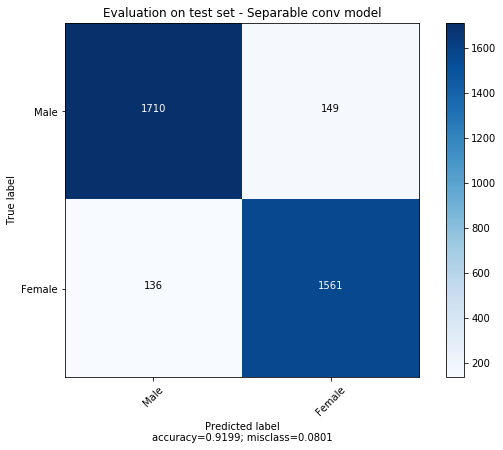

----------------------- Race prediction -------------------------
              precision    recall  f1-score   support

       White       0.80      0.88      0.84      1512
       Black       0.91      0.70      0.79       679
       Asian       0.78      0.85      0.81       515
      Indian       0.55      0.74      0.63       596
     Unknown       0.00      0.00      0.00       254

   micro avg       0.76      0.76      0.76      3556
   macro avg       0.61      0.64      0.62      3556
weighted avg       0.72      0.76      0.73      3556



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


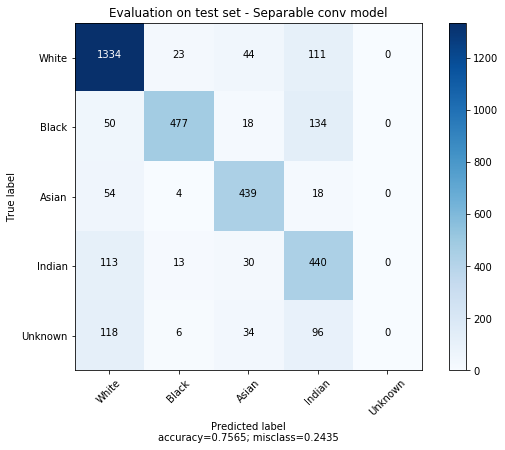

The execution took 0.0 hours | 0.0 minutes | 12.7 seconds!


In [35]:
evaluate_model(sep_conv_model, test_loader, title='Evaluation on test set - Separable conv model')

Evaluate resnet model


100%|██████████| 14/14 [00:13<00:00,  1.51it/s]


----------------------- Age prediction -------------------------
Mean Absolute Error 14.8409
----------------------- Gender prediction -------------------------
              precision    recall  f1-score   support

        Male       0.96      0.95      0.95      1859
      Female       0.95      0.95      0.95      1697

   micro avg       0.95      0.95      0.95      3556
   macro avg       0.95      0.95      0.95      3556
weighted avg       0.95      0.95      0.95      3556



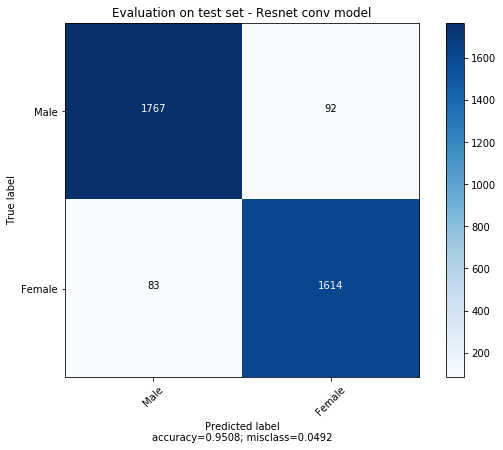

----------------------- Race prediction -------------------------
              precision    recall  f1-score   support

       White       0.85      0.96      0.90      1512
       Black       0.92      0.88      0.90       679
       Asian       0.91      0.90      0.91       515
      Indian       0.89      0.79      0.83       596
     Unknown       0.69      0.43      0.53       254

   micro avg       0.87      0.87      0.87      3556
   macro avg       0.85      0.79      0.81      3556
weighted avg       0.87      0.87      0.86      3556



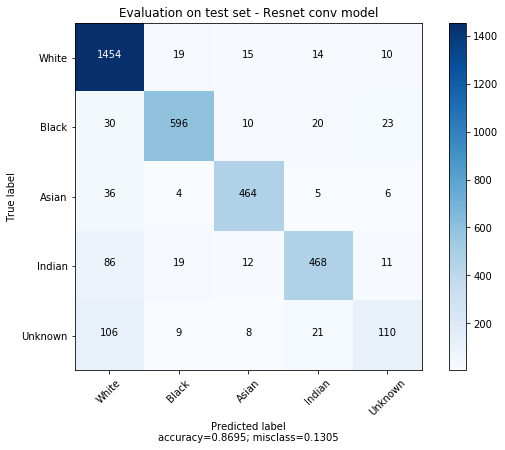

The execution took 0.0 hours | 0.0 minutes | 14.3 seconds!


In [37]:
evaluate_model(resnet_model, test_loader, title='Evaluation on test set - Resnet conv model')

Evaluate VGG model


100%|██████████| 14/14 [00:33<00:00,  2.19s/it]


----------------------- Age prediction -------------------------
Mean Absolute Error 15.3566
----------------------- Gender prediction -------------------------
              precision    recall  f1-score   support

        Male       0.98      0.93      0.96      1859
      Female       0.93      0.98      0.95      1697

   micro avg       0.95      0.95      0.95      3556
   macro avg       0.95      0.96      0.95      3556
weighted avg       0.96      0.95      0.95      3556



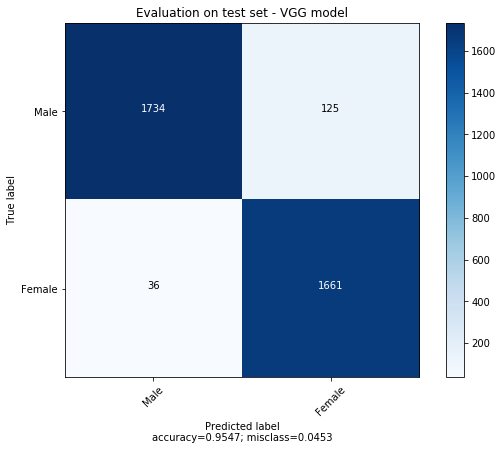

----------------------- Race prediction -------------------------
              precision    recall  f1-score   support

       White       0.93      0.92      0.93      1512
       Black       0.84      0.96      0.90       679
       Asian       0.91      0.94      0.93       515
      Indian       0.83      0.90      0.86       596
     Unknown       0.75      0.34      0.47       254

   micro avg       0.88      0.88      0.88      3556
   macro avg       0.85      0.81      0.82      3556
weighted avg       0.88      0.88      0.88      3556



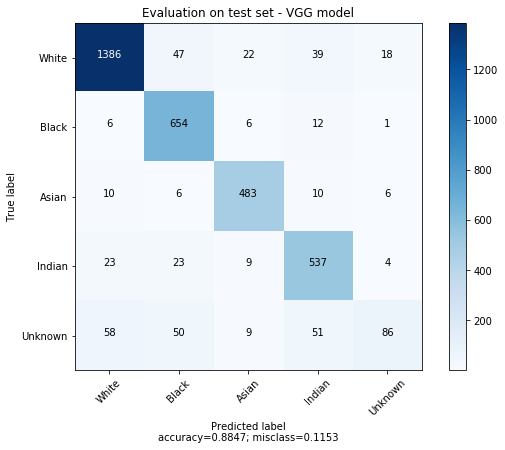

The execution took 0.0 hours | 0.0 minutes | 35.3 seconds!


In [38]:
evaluate_model(vgg_model, test_loader, title='Evaluation on test set - VGG model')